# Greenhouse Model

## Import dependencies and data

In [1]:
# import dependencies
import os
import pickle
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers, Model

In [2]:
# set plot defaults
plt.rcdefaults()

font = {
    'family' : 'arial',
    'weight' : 'normal',
    'size'   : 14
}

tit_font = {
    'family' : 'arial',
    'weight' : 'bold',
    'size'   : 16
}

suptit_font = {
    'family' : 'arial',
    'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)

In [3]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'
results_path = home_path + '\\model\\results\\'
kfold_path = home_path + '\\model\\kfold_results\\'

In [4]:
# get merged data
data = pd.read_csv(
    data_path + 'data_processed.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
#data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [5]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category  sensor_ID              
flow      TA01_GP101                 0
          TA02_GP101                 0
state     TA01_output                0
          TA02_output                0
power     phase                      0
                                    ..
humidity  TA01_GT401_GM401_scaled    0
          TA02_GT401_GM401_scaled    0
          outdoor_scaled             0
          TA_inflow                  0
          TA_inflow_out              0
Length: 68, dtype: int64





## MISC

In [6]:
def abs_humid(temp, rel_humid):
    abs_humidity =  6.112 * np.exp(17.67 * temp / (temp + 243.5)) * rel_humid * 2.1674 / (273.15 + temp)
    return abs_humidity

def rel_humid(temp, abs_humid):
    rel_humidity = abs_humid * (273.15 + temp) / (6.112 * np.exp(17.67 * temp / (temp + 243.5)) * 2.1674)
    return rel_humidity

In [7]:
ta01_min = 35
ta01_max = 75

ta02_min = 0
ta02_max = 85

## Define funcs. for Data ENG.

In [8]:
# # reduce to one OBS per 5 MIN (take average of 10 OBS)
def data_reduce(data, m):
    idxObj = zip(
        data.index.get_level_values(0),
        data.index.get_level_values(1),
        data.index.get_level_values(2),
        data.index.get_level_values(3) // m
    )

    index = pd.MultiIndex.from_tuples(
        tuples=idxObj,
        names=['month', 'day', 'hour', 'minute']
    )

    data.index = index
    dates = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).last()[('time', 'date')]
    data = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()
    return data, dates

In [9]:
def date_flagger(data, n_steps):
    # create flag for erroneous sequences
    data['hour'] = data.index.get_level_values(2).values    
    data['date_flag'] = data.hour - data.hour.shift(n_steps) > 1
    
    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['hour'], data['date_flag']
    
    return flagged_idx

In [10]:
def seq_maker(data, targets, temps, flows, n_steps):
    
    vals = data.values
    sequences = []
    for i in range(len(vals) - n_steps):
        sequences.append(vals[i:i+n_steps])
    sequences = np.stack(sequences)
    
    flags = date_flagger(data, n_steps)
    mask = [idx not in flags for idx in range(len(sequences))]
    
    sequences = sequences[mask]
    targets = targets[n_steps:][mask].values
    
    temps_t = temps[n_steps-t_steps:-t_steps][mask].values
    temps = temps[:-n_steps][mask].values # TEMPORARY
    
    flows = flows[:-n_steps][mask].values
    
    return sequences, targets, temps, temps_t, flows

In [11]:
def data_norm(data_train, data_test):
    col_params = {}
    for col in data_train.columns:

        min_val = data_train[col].min()
        max_val = data_train[col].max()

        # normalize
        mean = data_train[col].mean()
        std = data_train[col].std()

        data_train[col] = (data_train[col] - mean) / std
        data_test[col] = (data_test[col] - mean) / std

        col_params[col] = {
            'mean':mean,
            'std':std,
            'max':max_val,
            'min':min_val
            }
    
    return data_train, data_test, col_params

In [12]:
def k_fold_data(data, k_idx, k_frac, m, cols, t_steps, n_steps, shuffle):
    
    # get days
    days = data.groupby(['month', 'day'], sort=False).count().index.values
    
    # get days for K:th fold
    train_n = int(len(days)) * (1 - k_frac)
    test_n = len(days) - train_n
    
    # split days by test and train
    days_test = days[int(k_idx*test_n):int((k_idx+1)*test_n)].tolist()
    mask_test = np.array([day in days_test for day in data.index.droplevel(-1).droplevel(-1).droplevel(-1).values])
    data_train = data.loc[~mask_test].copy()
    data_test = data.loc[mask_test].copy()
    
    # reduce to m-min observations
    data_train, dates_train = data_reduce(data_train, m)
    data_test, dates_test = data_reduce(data_test, m)
    
#     # get dates
#     dates_train = data_train.time.date.values
#     dates_test = data_test.time.date.values
    
#     # remove setpoint
#     data_train[('temperatures', 'TA01_GT10X_GM10X')] -= data_train.setpoints.TA01_GT10X_GM10X + 20
#     data_test[('temperatures', 'TA01_GT10X_GM10X')] -= data_test.setpoints.TA01_GT10X_GM10X + 20
    
    # save full test data
    flows_train = data_train.state[['TA01_output', 'TA02_output']].copy()
    flows_test = data_test.state[['TA01_output', 'TA02_output']].copy()
    
    # filter data
    data_train = data_train[cols].copy()
    data_test = data_test[cols].copy()
    
    # normalize
    data_train, data_test, col_params = data_norm(data_train, data_test)
    
    # get targets
    targets_train = pd.concat([data_train.pop(col) for col in [
        ('temperatures', 'TA01_GT10X_GM10X'),
        ('humidity', 'TA01_GT10X_GM10X_abs')
    ]], axis=1)

    targets_test = pd.concat([data_test.pop(col) for col in [
        ('temperatures', 'TA01_GT10X_GM10X'),
        ('humidity', 'TA01_GT10X_GM10X_abs')
    ]], axis=1)
    
    # get temp info
    temps_train = targets_train.copy()
    temps_test = targets_test.copy()
    
    # get seqs
    sequences_train, targets_train, temps_train, temps_t_train, _ = seq_maker(data_train, targets_train, temps_train, flows_train, n_steps)
    sequences_test, targets_test, temps_test, temps_t_test, flows_test = seq_maker(data_test, targets_test, temps_test, flows_test, n_steps)
    
    dates_train, dates_test = None, None
    
    # create MASKED sequences
    sequences_masked = sequences_test.copy()
    for t in range(1, t_steps):
        sequences_masked[:, -t, :] = sequences_masked[:, -(t_steps), :]
    
    if shuffle:
        # shuffle training data randomly
        idxs = np.arange(len(targets_train))
        np.random.shuffle(idxs)

        sequences_train = sequences_train[idxs]
        targets_train = targets_train[idxs]
        temps_train = temps_train[idxs]
        temps_t_trian = temps_t_train[idxs]
       # dates_train = dates_train[idxs]
    
    # return tups w. train and test
    train_tup = (sequences_train, targets_train, temps_train, temps_t_train, dates_train)
    test_tup = (sequences_test, targets_test, temps_test, temps_t_test, sequences_masked, flows_test, dates_test)
    return train_tup, test_tup, col_params

In [13]:
# # Define model variables
# model_vars = [
# #     ('temperatures', 'TA_inflow'),
# #     ('humidity', 'TA_inflow'),
# #     ('temperatures', 'TA_inflow_out'),
# #     ('humidity', 'TA_inflow_out'),
# #     ('state', 'TA01_output'),
# #     ('state', 'TA02_output'),
# #     ('flow', 'TA01_GP101'),
# #     ('flow', 'TA02_GP101'),
# #     ('temperatures', 'DC_GT102_GM102'),
# #     ('temperatures', 'DC_GT103_GM103'),
# #     ('temperatures', 'DC_GT104_GM104'),
#     ('temperatures', 'TA01_GT10X_GM10X'),
#     ('temperatures', 'TA01_GT401_GM401_scaled'),
# #     ('temperatures', 'TA02_GT401_GM401_scaled'),
#     ('temperatures', 'DC_GT301_damped_scaled'),
# #     ('temperatures', 'DC_GT301_outdoor_scaled'),
# #     ('temperatures', 'DC_GT401_GM401'),
#     ('temperatures', 'TA01_GT401_GM401'),
#     ('temperatures', 'TA02_GT401_GM401'),
#     ('temperatures', 'DC_GT301_damped'),
# #     ('temperatures', 'DC_GT301_outdoor'),
# #     ('humidity', 'TA01_GT10X_GM10X'),
#     ('humidity', 'TA01_GT10X_GM10X_abs'),
#     ('humidity', 'TA01_GT401_GM401_abs'),
#     ('humidity', 'TA02_GT401_GM401_abs'),
#     ('humidity', 'outdoor_abs'),
#     ('humidity', 'TA01_GT401_GM401_scaled'),
# #     ('humidity', 'TA02_GT401_GM401_scaled'),
#     ('humidity', 'outdoor_scaled'),
#     ('sun', 'gsi'),
# #     ('sun', 'gsi_deriv'),
# #     ('sun', 'vol'),
# #     ('sun', 'vol_deriv'),
# #     ('wind', 'Wx'),
# #     ('wind', 'Wy'),
#     ('power', 'phase'),
#     ('time', 'minofday'),
#     ('time', 'dayofyear')
# ]


In [14]:
k_idx = 19
m = 5
t_steps = 3
n_steps = 12
k_frac = 0.05

# Define cols to use
cols = [
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'TA01_GT401_GM401_scaled'),
    ('temperatures', 'DC_GT301_damped_scaled'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('humidity', 'TA01_GT10X_GM10X_abs'),
    ('humidity', 'TA01_GT401_GM401_abs'),
    ('humidity', 'TA02_GT401_GM401_abs'),
    ('humidity', 'outdoor_abs'),
    ('humidity', 'TA01_GT401_GM401_scaled'),
    ('humidity', 'outdoor_scaled'),
    ('sun', 'gsi'),
    ('power', 'phase'),
    ('time', 'minofday'),
    ('time', 'dayofyear')
]

In [15]:
# get data
_, test_tup, col_params = k_fold_data(
    data=data, 
    k_idx=k_idx, 
    k_frac=k_frac, 
    m=m, 
    cols=cols, 
    t_steps=t_steps, 
    n_steps=n_steps,
    shuffle=True
)

# get test data
(sequences_test, targets_test, temps_test, temps_t_test, sequences_masked, flows_test, dates_test) = test_tup

## Test model

In [16]:
model_name = 'gh_lstm_w512_v4'
comp_model_name = 'gh_lstm_w128_v3'

In [16]:
tf.keras.backend.clear_session()

In [17]:
model = tf.keras.models.load_model(save_path + model_name + '_X')
comp_model = tf.keras.models.load_model(save_path + comp_model_name + '_X')
encoder = tf.keras.models.load_model(save_path + model_name + '_encoder')

## Results

In [21]:
#preds = np.squeeze(model.predict([sequences_test, temps_test]))
preds_masked = np.squeeze(model.predict([sequences_masked, temps_t_test]))
comp_preds_masked = np.squeeze(comp_model.predict([sequences_masked, temps_t_test]))

64/64 [==============================] - 1s 8ms/step


## Predictions

In [24]:
# temps = targets_test[:, 0] * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean']
# humid = targets_test[:, 1] * col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['std'] + col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['mean']

temps = normalize_inv(targets_test[:, 0], col_params[('temperatures', 'TA01_GT10X_GM10X')])
humid = normalize_inv(targets_test[:, 1], col_params[('humidity', 'TA01_GT10X_GM10X_abs')])

# temp_preds = preds[:, 0] * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean']
# humid_preds = preds[:, 1] * col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['std'] + col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['mean']
temp_preds = normalize_inv(preds_masked[:, 0], col_params[('temperatures', 'TA01_GT10X_GM10X')])
humid_preds = normalize_inv(preds_masked[:, 1], col_params[('humidity', 'TA01_GT10X_GM10X_abs')])
temp_preds_comp = normalize_inv(comp_preds_masked[:, 0], col_params[('temperatures', 'TA01_GT10X_GM10X')])
humid_preds_comp = normalize_inv(comp_preds_masked[:, 1], col_params[('humidity', 'TA01_GT10X_GM10X_abs')])

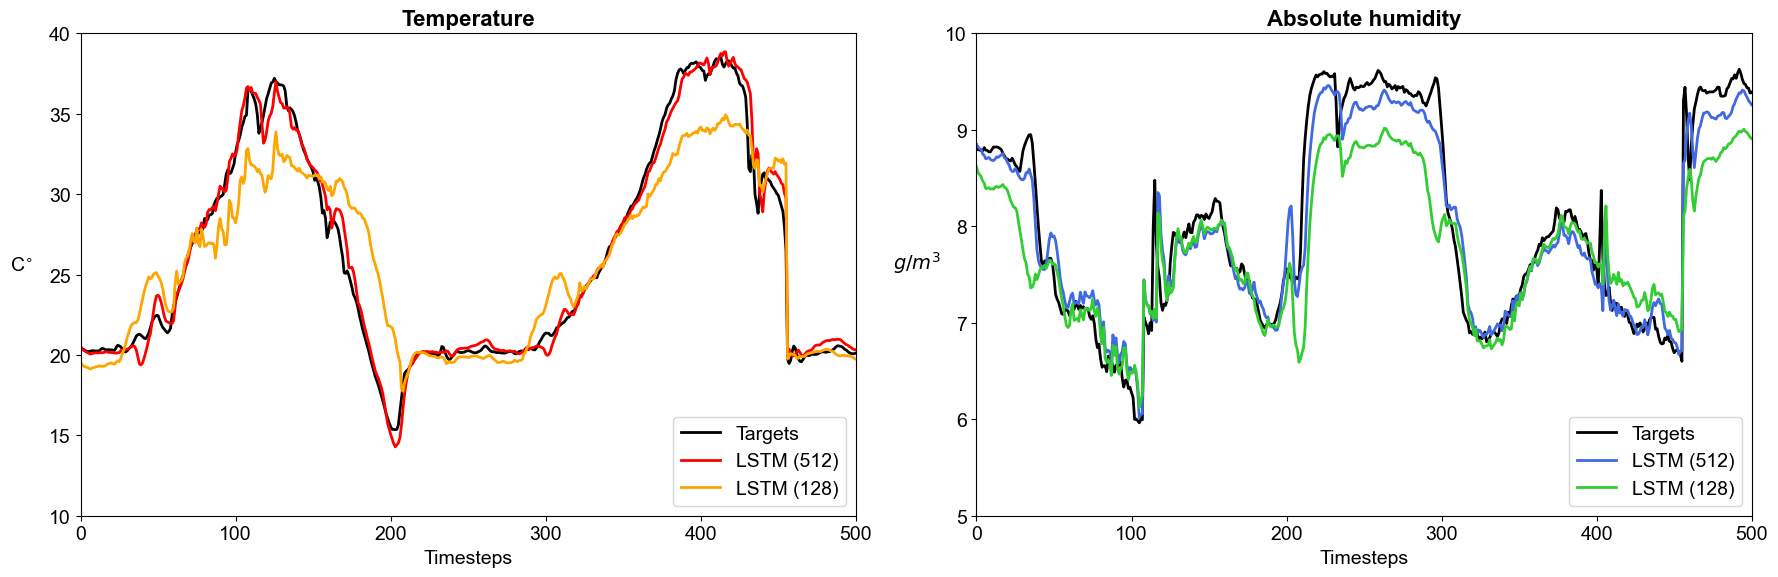

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

ax1.plot(temps, c='black', linewidth=2, label='Targets')
ax1.plot(temp_preds, c='red', linewidth=2, alpha=1.0, label='LSTM (512)')
ax1.plot(temp_preds_comp, c='orange', linewidth=2, alpha=1.0, label='LSTM (128)')
ax1.set_xlim(0, 500)
ax1.set_ylim(10, 40)
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('C$^{\circ}$', rotation=0, labelpad=20)
ax1.legend(loc='lower right')
ax1.set_title('Temperature', **tit_font)

ax2.plot(humid, c='black', linewidth=2, label='Targets')
ax2.plot(humid_preds, c='royalblue', linewidth=2, alpha=1.0, label='LSTM (512)')
ax2.plot(humid_preds_comp, c='limegreen', linewidth=2, alpha=1.0, label='LSTM (128)')
ax2.set_xlim(0, 500)
ax2.set_ylim(5, 10)
ax2.set_xlabel('Timesteps')
ax2.set_ylabel('$g/m^3$', rotation=0, labelpad=20)
ax2.legend(loc='lower right')
ax2.set_title('Absolute humidity', **tit_font)

#fig.suptitle('Predictions', **suptit_font)
fig.tight_layout()

plt.savefig(plot_path + 'model_preds.png', dpi=200, bbox_inches='tight')
plt.show()

In [46]:
temp_mse_512 = np.square(targets_test[:, 0] - np.stack(normalize(temp_preds, col_params[('temperatures', 'TA01_GT10X_GM10X')])).flatten()).mean()
temp_mse_128 = np.square(targets_test[:, 0] - np.stack(normalize(temp_preds_comp, col_params[('temperatures', 'TA01_GT10X_GM10X')])).flatten()).mean()

humid_mse_512 = np.square(targets_test[:, 1] - np.stack(normalize(humid_preds, col_params[('humidity', 'TA01_GT10X_GM10X_abs')])).flatten()).mean()
humid_mse_128 = np.square(targets_test[:, 1] - np.stack(normalize(humid_preds_comp, col_params[('humidity', 'TA01_GT10X_GM10X_abs')])).flatten()).mean()

## Autoregressive predictions

In [34]:
# create queue for preds
pred_queue_128, pred_queue_512 = deque(maxlen=t_steps), deque(maxlen=t_steps)
for temp in temps_t_test[:t_steps]:
    pred_queue_128.append(temp)
    pred_queue_512.append(temp)
    
lstm_preds_128, lstm_preds_512 = [], []
for seq in sequences_masked:
        # get pred f. 128-unit LSTM
        temp = np.array([pred_queue_128.popleft()])
        temp_pred = comp_model.predict([seq[np.newaxis, :], temp], verbose=False)[0]
        pred_queue_128.append(temp_pred)
        lstm_preds_128.append(temp_pred)
        
        # get pred f. 512-unit LSTM
        temp = np.array([pred_queue_512.popleft()])
        temp_pred = model.predict([seq[np.newaxis, :], temp], verbose=False)[0]
        pred_queue_512.append(temp_pred)
        lstm_preds_512.append(temp_pred)
        
lstm_preds_128 = np.stack(lstm_preds_128)
lstm_preds_512 = np.stack(lstm_preds_512)       

In [56]:
temp_mse_512 = np.square(targets_test[:, 0] - lstm_preds_512[:, 0]).mean()
temp_mse_128 = np.square(targets_test[:, 0] - lstm_preds_128[:, 0]).mean()

humid_mse_512 = np.square(targets_test[:, 1] - np.stack(normalize(lstm_preds_512[:, 1], col_params[('humidity', 'TA01_GT10X_GM10X_abs')])).flatten()).mean()
humid_mse_128 = np.square(targets_test[:, 1] - np.stack(normalize(lstm_preds_128[:, 1], col_params[('humidity', 'TA01_GT10X_GM10X_abs')])).flatten()).mean()

In [59]:
temp_mse_128

1.866935287286178

In [37]:
temp_preds = normalize_inv(lstm_preds_512[:, 0], col_params[('temperatures', 'TA01_GT10X_GM10X')])
humid_preds = normalize_inv(lstm_preds_512[:, 1], col_params[('humidity', 'TA01_GT10X_GM10X_abs')])
temp_preds_comp = normalize_inv(lstm_preds_128[:, 0], col_params[('temperatures', 'TA01_GT10X_GM10X')])
humid_preds_comp = normalize_inv(lstm_preds_128[:, 1], col_params[('humidity', 'TA01_GT10X_GM10X_abs')])

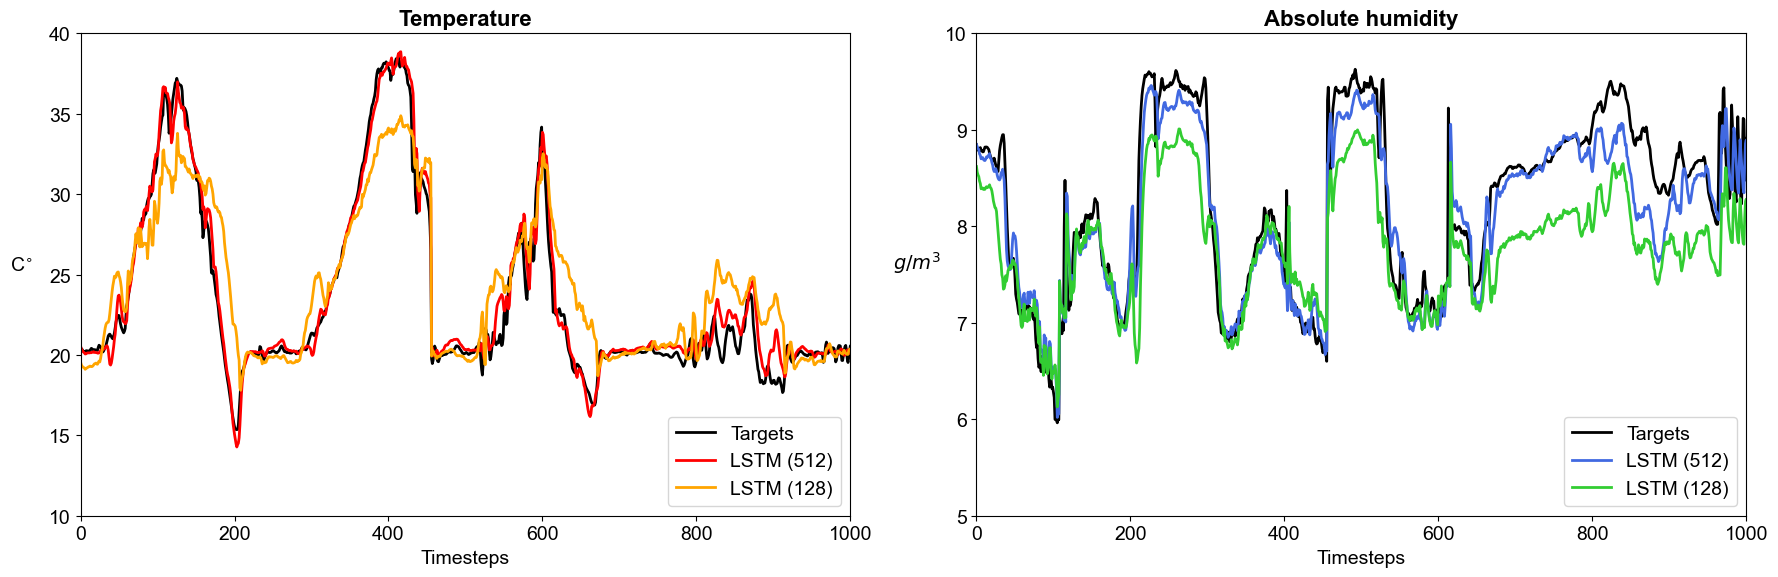

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

ax1.plot(temps, c='black', linewidth=2, label='Targets')
ax1.plot(temp_preds, c='red', linewidth=2, alpha=1.0, label='LSTM (512)')
ax1.plot(temp_preds_comp, c='orange', linewidth=2, alpha=1.0, label='LSTM (128)')
ax1.set_xlim(0, 1000)
ax1.set_ylim(10, 40)
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('C$^{\circ}$', rotation=0, labelpad=20)
ax1.legend(loc='lower right')
ax1.set_title('Temperature', **tit_font)

ax2.plot(humid, c='black', linewidth=2, label='Targets')
ax2.plot(humid_preds, c='royalblue', linewidth=2, alpha=1.0, label='LSTM (512)')
ax2.plot(humid_preds_comp, c='limegreen', linewidth=2, alpha=1.0, label='LSTM (128)')
ax2.set_xlim(0, 1000)
ax2.set_ylim(5, 10)
ax2.set_xlabel('Timesteps')
ax2.set_ylabel('$g/m^3$', rotation=0, labelpad=20)
ax2.legend(loc='lower right')
ax2.set_title('Absolute humidity', **tit_font)

#fig.suptitle('Predictions', **suptit_font)
fig.tight_layout()

plt.savefig(plot_path + 'model_preds_autoreg.png', dpi=200, bbox_inches='tight')
plt.show()

## Comparison to ARIMA

In [16]:
# load k-fold results dict
with open(kfold_path + 'k_fold_results.pickle', 'rb') as fo:
    results_dict = pickle.load(fo)

In [17]:
lstm_mse, lstm_simp_mse, lstm_midsimp_mse, arima_mse, gbdt_mse, gbdt_large_mse = zip(*[(
    results_dict[k]['lstm_mse'], 
    results_dict[k]['lstm_simp_mse'], 
    results_dict[k]['lstm_midsimp_mse'],
    results_dict[k]['arima_mse'], 
    results_dict[k]['gbdt_mse'], 
    results_dict[k]['gbdt_large_mse']) 
for k in range(20)])

lstm_mse = np.array(lstm_mse)
lstm_simp_mse = np.array(lstm_simp_mse)
lstm_midsimp_mse = np.array(lstm_midsimp_mse)
arima_mse = np.array(arima_mse)
gbdt_mse = np.array(gbdt_mse)
gbdt_large_mse = np.array(gbdt_large_mse)

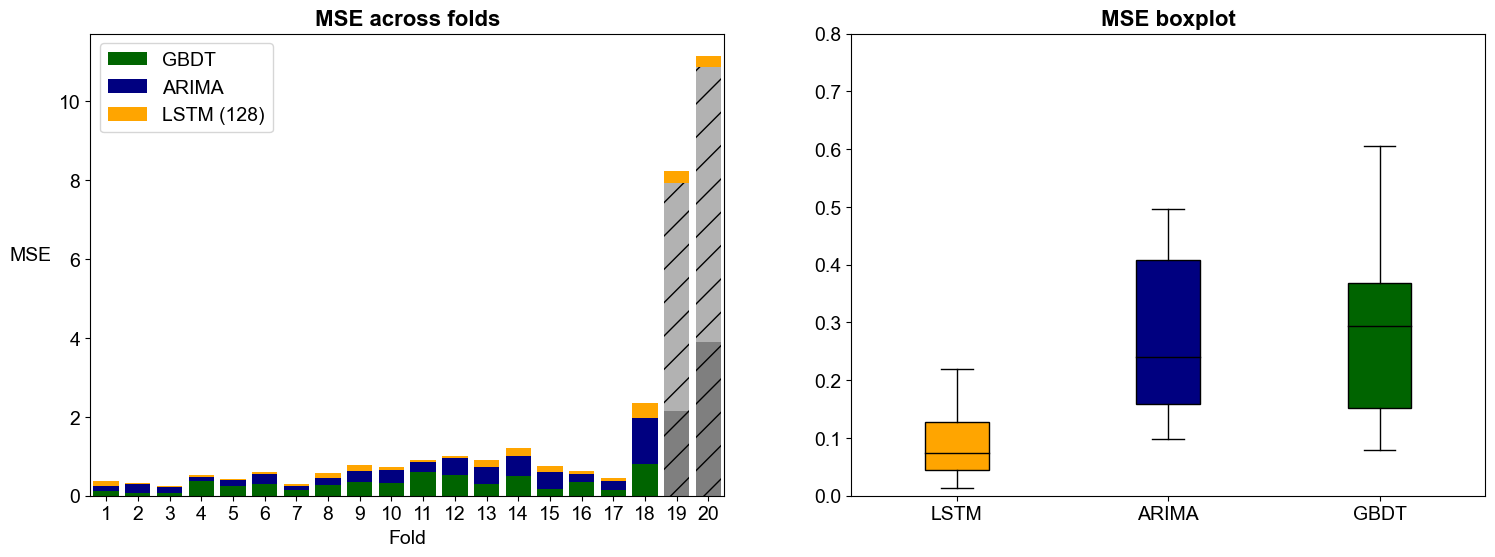

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

ax1.bar(range(1, 19), gbdt_mse[:-2], color='darkgreen', label='GBDT')
ax1.bar(range(1, 19), arima_mse[:-2], bottom=gbdt_mse[:-2], color='navy', label='ARIMA')
ax1.bar(range(1, 19), lstm_mse[:-2], bottom=arima_mse[:-2] + gbdt_mse[:-2], color='orange', label='LSTM (128)')
# ax1.bar(range(1, 21), gbdt_large_mse)

ax1.bar(range(19, 21), gbdt_mse[-2:], color='black', alpha=0.5, hatch='/')
ax1.bar(range(19, 21), arima_mse[-2:], bottom=gbdt_mse[-2:], color='black', alpha=0.3, hatch='/')
ax1.bar(range(19, 21), lstm_mse[-2:], bottom=gbdt_mse[-2:] + arima_mse[-2:], color='orange', alpha=1.0)

# ax1.bar(range(1, 19), gbdt_large_mse[:-2], width=0.2, color='green', label='GBDT')
# ax1.bar(np.arange(1, 19)+0.2, gbdt_mse[:-2], width=0.2, color='darkgreen', label='GBDT')
# ax1.bar(np.arange(1, 19)+0.4, arima_mse[:-2], width=0.2, color='navy', label='ARIMA') #bottom=gbdt_mse[:-2], color='navy', label='ARIMA')
# ax1.bar(np.arange(1, 19)+0.6, lstm_mse[:-2], width=0.2, color='orange', label='LSTM') #bottom=arima_mse[:-2] + gbdt_mse[:-2], color='orange', label='LSTM (128)')

# ax1.bar(range(19, 21), arima_mse[-2:], color='black', alpha=0.5, hatch='/')
# ax1.bar(range(19, 21), gbdt_mse[-2:], bottom=arima_mse[-2:], color='black', alpha=0.3, hatch='/')
# ax1.bar(range(19, 21), lstm_mse[-2:], bottom=gbdt_mse[-2:] + arima_mse[-2:], color='orange', alpha=1.0)


ax1.set_xlim(0.5, 20.5)
ax1.set_xticks(range(1, 21))
ax1.set_xlabel('Fold')
ax1.set_ylabel('MSE', rotation=0, labelpad=20)
ax1.legend(loc='upper left')
ax1.set_title('MSE across folds', **tit_font)

#ax2.set_facecolor('')
#ax2.grid()
# bplot = ax2.boxplot([gbdt_large_mse[:-2], gbdt_mse[:-2], arima_mse[:-2], lstm_mse[:-2]], patch_artist=True, showfliers=False)
bplot = ax2.boxplot([lstm_mse[:-2], arima_mse[:-2], gbdt_mse[:-2]], patch_artist=True, showfliers=False)
ax2.set_ylim(0, 0.8)
ax2.set_xticklabels(['LSTM', 'ARIMA', 'GBDT'])#, 'GBDT', 'ARIMA', 'LSTM'])
ax2.set_title('MSE boxplot', **tit_font)

# fill with colors
# colors = ['green', 'lightgreen', 'navy', 'orange']
colors = ['orange', 'navy', 'darkgreen']
for patch, color, median in zip(bplot['boxes'], colors, bplot['medians']):
    patch.set_facecolor(color)
    median.set_color('black')

plt.savefig(plot_path + 'model_comp.png', dpi=200, bbox_inches='tight')
plt.show()

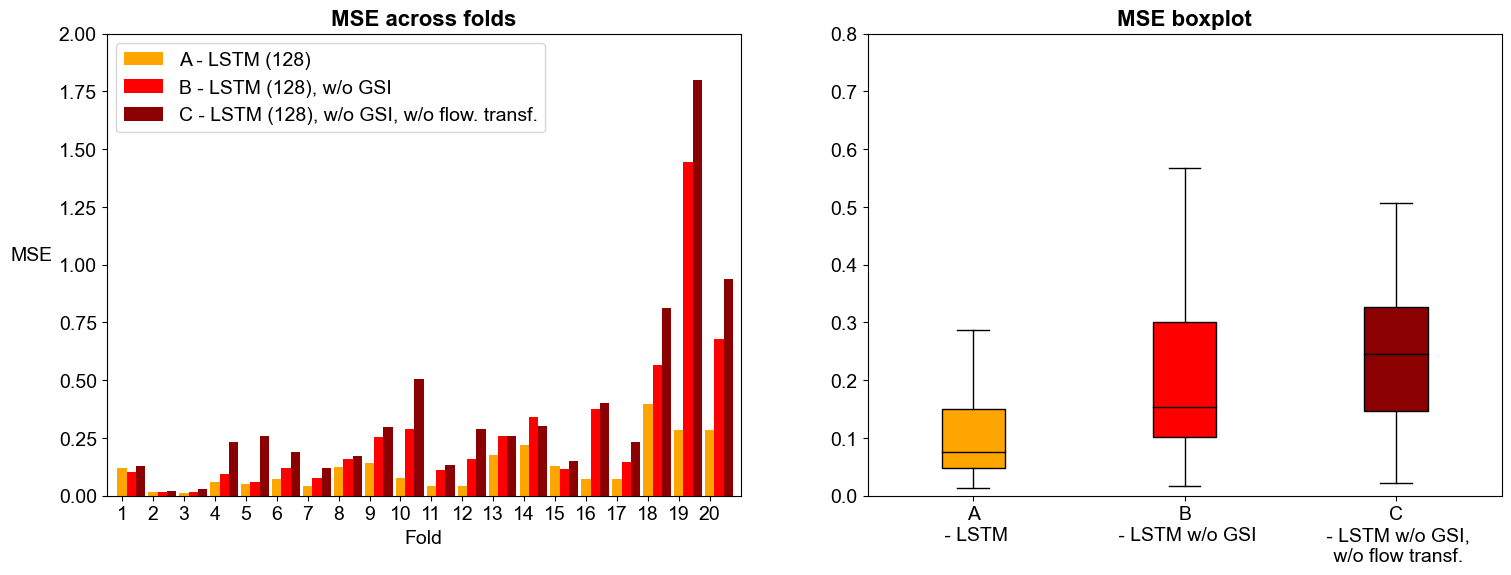

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

ax1.bar(np.arange(1, 21)+0.0, lstm_mse, width=0.3, bottom=0, color='orange', label='A - LSTM (128)')
ax1.bar(np.arange(1, 21)+0.3, lstm_midsimp_mse, width=0.3, bottom=0, color='red', label='B - LSTM (128), w/o GSI')
ax1.bar(np.arange(1, 21)+0.6, lstm_simp_mse, width=0.3, color='darkred', label='C - LSTM (128), w/o GSI, w/o flow. transf.')

# ax1.bar(range(19, 21), gbdt_mse[-2:], color='black', alpha=0.5, hatch='/')
# ax1.bar(range(19, 21), arima_mse[-2:], bottom=gbdt_mse[-2:], color='black', alpha=0.3, hatch='/')
# ax1.bar(range(19, 21), lstm_mse[-2:], bottom=gbdt_mse[-2:] + arima_mse[-2:], color='orange', alpha=1.0)

# ax1.bar(range(1, 19), gbdt_large_mse[:-2], width=0.2, color='green', label='GBDT')
# ax1.bar(np.arange(1, 19)+0.2, gbdt_mse[:-2], width=0.2, color='darkgreen', label='GBDT')
# ax1.bar(np.arange(1, 19)+0.4, arima_mse[:-2], width=0.2, color='navy', label='ARIMA') #bottom=gbdt_mse[:-2], color='navy', label='ARIMA')
# ax1.bar(np.arange(1, 19)+0.6, lstm_mse[:-2], width=0.2, color='orange', label='LSTM') #bottom=arima_mse[:-2] + gbdt_mse[:-2], color='orange', label='LSTM (128)')

# ax1.bar(range(19, 21), arima_mse[-2:], color='black', alpha=0.5, hatch='/')
# ax1.bar(range(19, 21), gbdt_mse[-2:], bottom=arima_mse[-2:], color='black', alpha=0.3, hatch='/')
# ax1.bar(range(19, 21), lstm_mse[-2:], bottom=gbdt_mse[-2:] + arima_mse[-2:], color='orange', alpha=1.0)


ax1.set_xlim(0.5, 21)
ax1.set_ylim(0, 2)
ax1.set_xticks(range(1, 21))
ax1.set_xlabel('Fold')
ax1.set_ylabel('MSE', rotation=0, labelpad=20)
ax1.legend(loc='upper left')
ax1.set_title('MSE across folds', **tit_font)

#ax2.set_facecolor('')
#ax2.grid()
# bplot = ax2.boxplot([gbdt_large_mse[:-2], gbdt_mse[:-2], arima_mse[:-2], lstm_mse[:-2]], patch_artist=True, showfliers=False)
bplot = ax2.boxplot([lstm_mse, lstm_midsimp_mse, lstm_simp_mse], patch_artist=True, showfliers=False)
ax2.set_ylim(0, 0.8)
ax2.set_xticklabels(['A\n - LSTM', 'B\n - LSTM w/o GSI', 'C\n - LSTM w/o GSI,\n w/o flow transf.'])#, 'GBDT', 'ARIMA', 'LSTM'])
ax2.set_title('MSE boxplot', **tit_font)

# fill with colors
# colors = ['green', 'lightgreen', 'navy', 'orange']
colors = ['orange', 'red', 'darkred']
for patch, color, median in zip(bplot['boxes'], colors, bplot['medians']):
    patch.set_facecolor(color)
    median.set_color('black')

plt.savefig(plot_path + 'model_lstm_comp.png', dpi=200, bbox_inches='tight')
plt.show()

In [69]:
from scipy.stats import wilcoxon

test = wilcoxon(lstm_simp_mse, arima_mse)
# test = wilcoxon(arima_mse[:-2], gbdt_mse[:-2])

In [70]:
test.pvalue

0.04844093322753906

In [74]:
gbdt_mse.mean()

0.5848612796343431

## PCA on ecoded stataes

In [52]:
from sklearn.decomposition import PCA

decomposer = PCA(n_components=5)

In [53]:
encodings = encoder.predict(sequences_masked)
decomposed = decomposer.fit_transform(X=encodings)

64/64 [==============================] - 5s 62ms/step


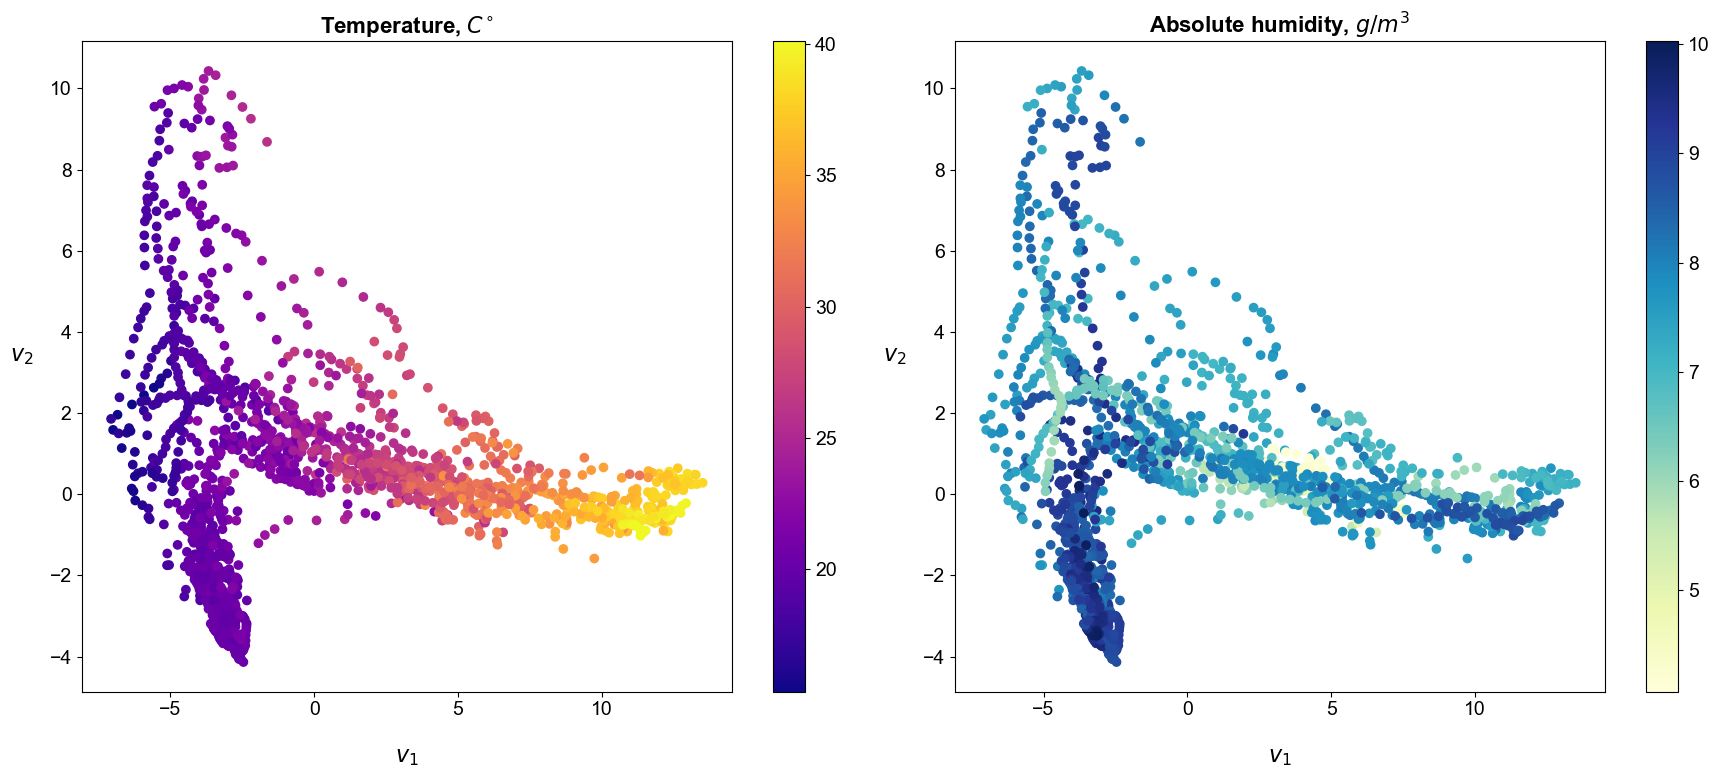

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 8)

scatter = ax1.scatter(decomposed[:, 0], decomposed[:, 1], c=temps, cmap='plasma')# cmap='YlOrBr')
fig.colorbar(scatter, ax=ax1)
ax1.set_ylabel('$v_2$', rotation=0, labelpad=20, fontsize=16)
ax1.set_xlabel('$v_1$', labelpad=20, fontsize=16)
ax1.set_title('Temperature, $C^{\circ}$', **tit_font)

scatter = ax2.scatter(decomposed[:, 0], decomposed[:, 1], c=humid, cmap='YlGnBu')
fig.colorbar(scatter, ax=ax2)
ax2.set_ylabel('$v_2$', rotation=0, labelpad=20, fontsize=16)
ax2.set_xlabel('$v_1$', labelpad=20, fontsize=16)
ax2.set_title('Absolute humidity, $g/m^3$', **tit_font)

# fig.suptitle('Encoded states for test set predictions', **suptit_font)
fig.tight_layout()

plt.savefig(plot_path + 'model_encodings.png', dpi=200, bbox_inches='tight')
plt.show()

## Heatmaps

In [17]:
def normalize(array, params):
    return (array - params['mean']) / params['std']

def normalize_inv(array, params):
    return (array * params['std']) + params['mean']

In [38]:
# define func for heatmap estimations
# input seqs, temps, humids, etc., RETURN grid w. temps and humids
def grid_estimation(seq, k, temps_test, col_params, ta_lims, model):
    
    ta01_min, ta01_max, ta02_min, ta02_max = ta_lims

    temp = normalize_inv(temps_test[0], col_params[('temperatures', 'TA01_GT10X_GM10X')])
    humid = normalize_inv(temps_test[1], col_params[('humidity', 'TA01_GT10X_GM10X_abs')])
    
    ta01_minmax = np.arange(ta01_min, ta01_max, (ta01_max - ta01_min) / k) / ta01_min
    ta02_minmax = np.arange(ta02_min, ta02_max, (ta02_max - ta02_min) / k) / ta01_min

    temp_dc = -temp + normalize_inv(seq[:, 2].copy(), col_params[('temperatures', 'TA01_GT401_GM401')])
    temp_out = -temp + normalize_inv(seq[:, 4].copy(), col_params[('temperatures', 'DC_GT301_damped')])
    
    print(temp_dc[-t_steps], temp_out[-t_steps])
    
    humid_dc = -humid + normalize_inv(seq[:, 5].copy(), col_params[('humidity', 'TA01_GT401_GM401_abs')])
    humid_out = -humid + normalize_inv(seq[:, 7].copy(), col_params[('humidity', 'outdoor_abs')])
    
    seqs = []

    for j in range(k):
        for i in range(k):

            seq_mod = seq.copy()

            ta01_temp = temp_dc * ta01_minmax[i]
            ta02_temp = temp_out * ta02_minmax[j]
            ta01_temp = normalize(ta01_temp, col_params[('temperatures', 'TA01_GT401_GM401_scaled')])
            ta02_temp = normalize(ta02_temp, col_params[('temperatures', 'DC_GT301_damped_scaled')])
            
            ta01_humid = humid_dc * ta01_minmax[i]
            ta02_humid = humid_out * ta02_minmax[j]
            ta01_humid = normalize(ta01_humid, col_params[('humidity', 'TA01_GT401_GM401_scaled')])
            ta02_humid = normalize(ta02_humid, col_params[('humidity', 'outdoor_scaled')])
            
            seq_mod[-t_steps:, 0] = ta01_temp[-t_steps:]
            seq_mod[-t_steps:, 1] = ta02_temp[-t_steps:]
            seq_mod[-t_steps:, 8] = ta01_humid[-t_steps:]
            seq_mod[-t_steps:, 9] = ta02_humid[-t_steps:]

            seqs.append(seq_mod)

    seqs = np.stack(seqs)
    return seqs

In [39]:
k = 100
n = 0

In [40]:
ta_lims = [ta01_min, ta01_max, ta02_min, ta02_max]
seq = sequences_masked[n, :, :].copy()

seqs = grid_estimation(seq, k, temps_t_test[n], col_params, ta_lims, model)
preds = model.predict([seqs, np.ones((10000, 1)) * temps_t_test[n]])
temps = np.reshape(preds[:, 0], (k, k)) * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean']
humids = rel_humid(temps, np.reshape(preds[:, 1], (k, k)) * col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['std'] + col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['mean'])

23.246666666666663 -13.523333333333333
313/313 [==============================] - 22s 70ms/step


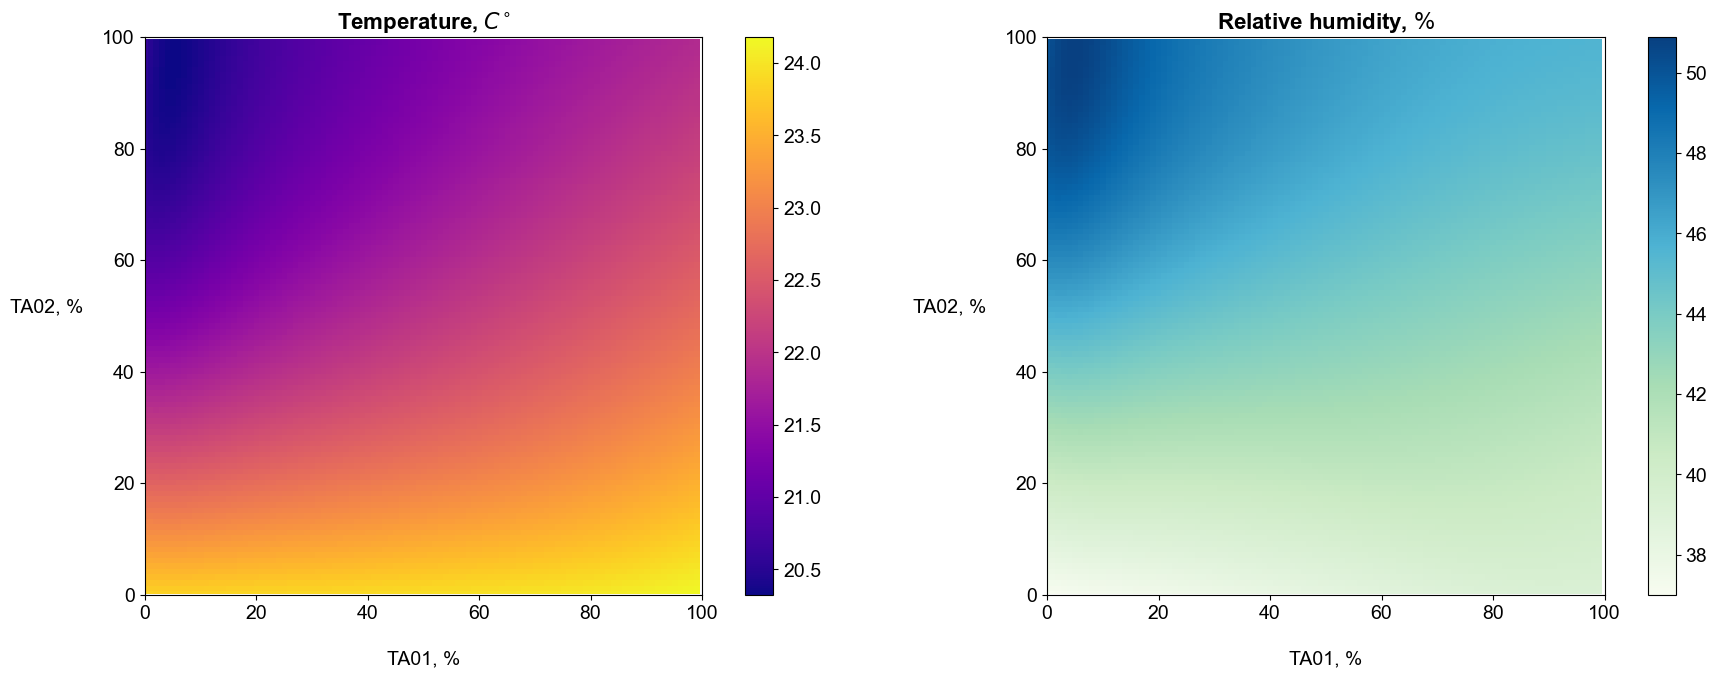

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

heatmap = ax1.imshow(np.flip(temps, 0), cmap='plasma')#, extent=[ta01_min, ta01_max, ta02_min, ta02_max])
fig.colorbar(heatmap, ax=ax1)
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 100)
ax1.set_ylabel('TA02, %', rotation=0, labelpad=40)
ax1.set_xlabel('TA01, %', labelpad=20)
ax1.set_title('Temperature, $C^{\circ}$', **tit_font)

heatmap = ax2.imshow(np.flip(humids, 0), cmap='GnBu')
fig.colorbar(heatmap, ax=ax2)
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 100)
ax2.set_ylabel('TA02, %', rotation=0, labelpad=40)
ax2.set_xlabel('TA01, %', labelpad=20)
ax2.set_title('Relative humidity, $\%$', **tit_font)

#fig.suptitle('Heatmaps', **suptit_font)
fig.tight_layout(pad=-1.5)

# plt.savefig(plot_path + 'model_heatmap.png', dpi=200, bbox_inches='tight')
plt.show()

## Nelder-Mead

In [42]:
from scipy.optimize import minimize

In [43]:
setpoint = 20
obj = np.abs(temps - setpoint)

def ta_temp(ta_input):
    ta01, ta02 = ta_input
    return obj[int(ta01), int(ta02)]

In [44]:
opt = minimize(fun=ta_temp, x0=(50, 50), method='Nelder-Mead', bounds=[(0, 100), (0, 100)])
opt.x[1] = k - opt.x[1]

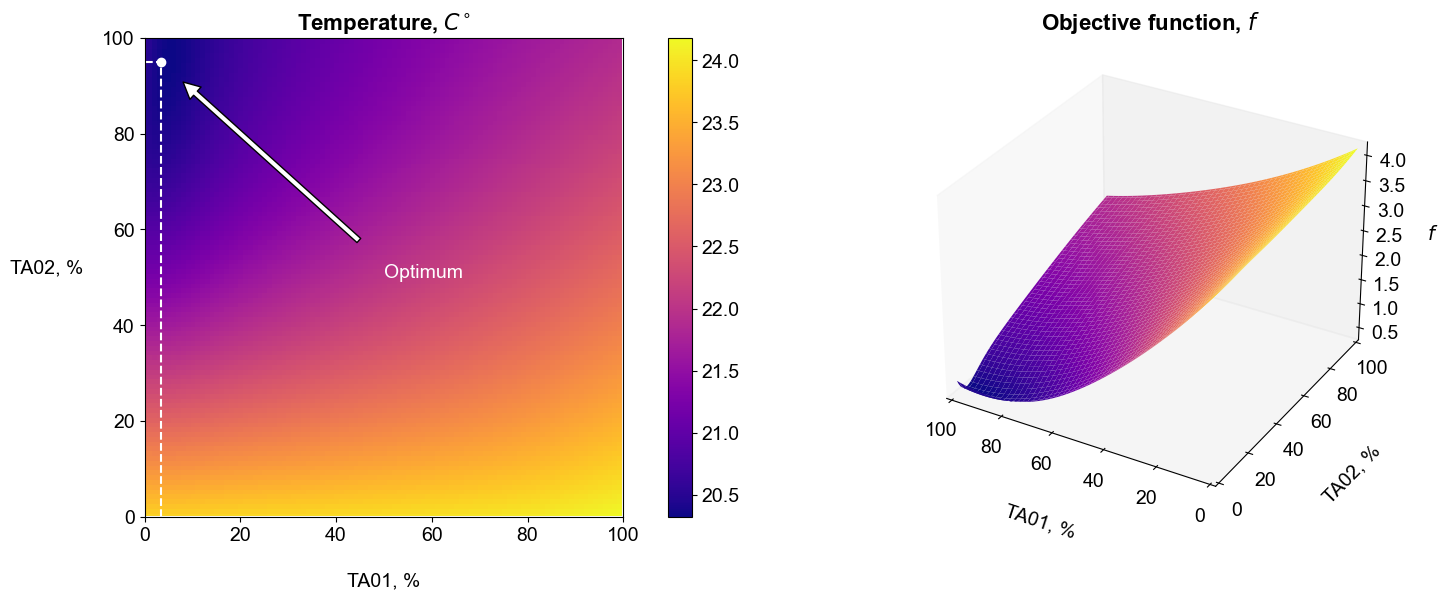

In [45]:
fig = plt.figure()
fig.set_size_inches(18, 6)

ax1 = fig.add_subplot(1, 2, 1)
heatmap = ax1.imshow(np.flip(temps, 0), cmap='plasma')
fig.colorbar(heatmap, ax=ax1)

ax1.set_xlim(0, k)
ax1.set_ylim(0, k)
ax1.set_ylabel('TA02, %', rotation=0, labelpad=40)
ax1.set_xlabel('TA01, %', labelpad=20)
ax1.set_title('Temperature, $C^{\circ}$', **tit_font)

# annotate w. optimal solution
ax1.scatter(opt.x[0], opt.x[1], marker='o', linewidth=1.0, color='white')
ax1.annotate('Optimum', fontsize=14, color='white', xy=opt.x, xytext=(50, 50), arrowprops=dict(facecolor='white', shrink=0.1))

ax1.hlines(opt.x[1], 0, opt.x[0], ls='--', color='white')
ax1.vlines(opt.x[0], 0, opt.x[1], ls='--', color='white')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
X, Y = np.meshgrid(range(0, 100), range(0, 100))
ax2.plot_surface(X=X, Y=Y, Z=np.flip(obj, 0).T, cmap='plasma')
ax2.grid(False)

ax2.set_xlim(100, 0)
ax2.set_ylim(0, 100)

ax2.set_xlabel('TA01, %', rotation=0, labelpad=20)
ax2.set_ylabel('TA02, %', rotation=0, labelpad=20)
ax2.set_zlabel('$f$', rotation=0, labelpad=10)
ax2.set_title('Objective function, $f$', **tit_font)


fig.tight_layout(pad=0.5)
plt.savefig(plot_path + 'model_heatmap_opt.png', dpi=200, bbox_inches='tight')
plt.show()


## Testing with re-calculated flows

In [23]:
# loading flow save dict
lstm_name = 'gh_lstm_w512_v4_X'
with open(results_path + '{}_opt_flow_autoreg_dict_init.pickle'.format(lstm_name), 'rb') as fo:
    results = pickle.load(fo)

In [24]:
ta01_flow, ta02_flow = zip(*[flow for flow in results['flow']])

In [25]:
# # smooth out ta01_flow and ta02_flow
# alpha = 0.8
# ta01_smooth, ta02_smooth = 0, 0
# ta01_flow_smooth, ta02_flow_smooth = [], []
# for ta01, ta02 in zip(ta01_flow, ta02_flow):
#     ta01_smooth = alpha * ta01_smooth + (1 - alpha) * ta01
#     ta02_smooth = alpha * ta02_smooth + (1 - alpha) * ta02
    
#     ta01_flow_smooth.append(ta01_smooth)
#     ta02_flow_smooth.append(ta02_smooth)

In [26]:
prev_max, prev_min = 99, 0
prev_range = 99 - 0
ta01_range = ta01_max - ta01_min
ta02_range = ta02_max - ta02_min

In [27]:
# rescale TA01 flow
ta01_flow = ((np.array(ta01_flow) - prev_min) * ta01_range / prev_range) + ta01_min
ta02_flow = ((np.array(ta02_flow) - prev_min) * ta02_range / prev_range) + ta02_min

# ta01_flow_smooth = ((np.array(ta01_flow_smooth) - prev_min) * ta01_range / prev_range) + ta01_min
# ta02_flow_smooth = ((np.array(ta02_flow_smooth) - prev_min) * ta02_range / prev_range) + ta02_min

In [28]:
n = 500

In [29]:
temps = normalize_inv(temps_t_test[:, 0], col_params[('temperatures', 'TA01_GT10X_GM10X')])

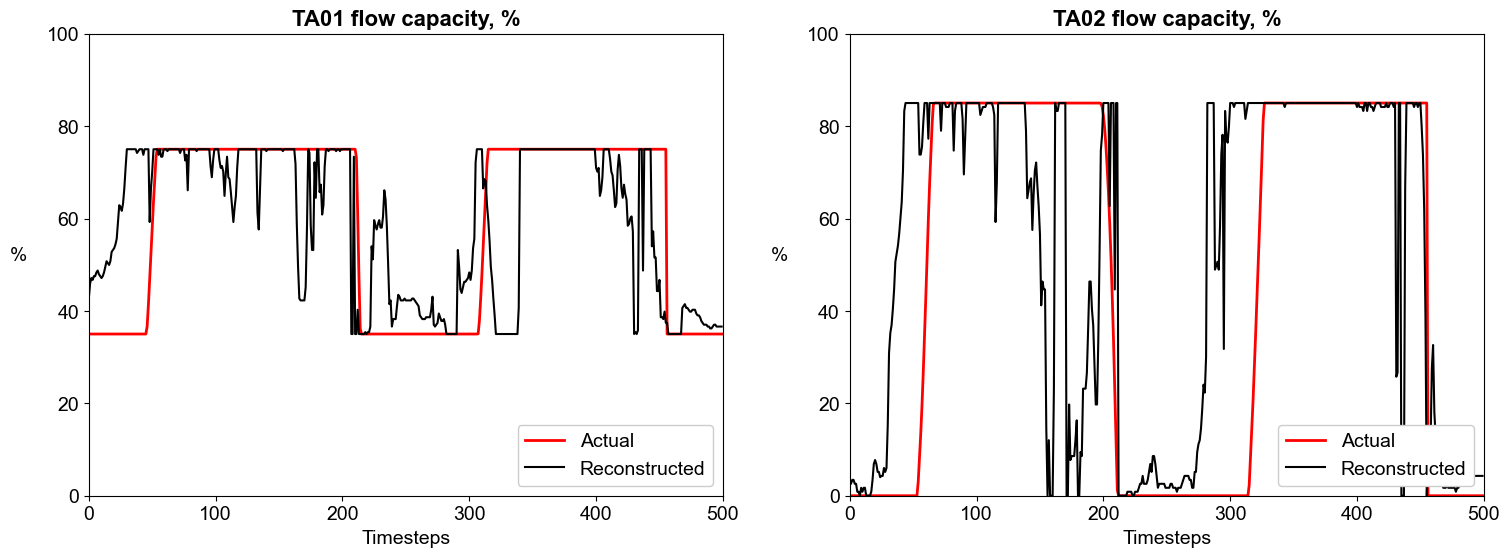

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

# # ax1.plot(data_test.temperatures.TA01_GT401_GM401.values[:n])
# # ax1.plot(data_test.temperatures.TA02_GT401_GM401.values[:n])
# ax1.plot(data_test_full.temperatures.TA01_GT10X_GM10X.values[:n], color='orange', label='Actual')
# ax1.plot(data_test_full.setpoints.TA01_GT10X_GM10X.values[:n], color='black', ls='--', label='Setpoint')
# ax1.set_xlim(0, n)
# #ax1.set_ylim(10, 40)
# ax1.set_title('GH Temperature, $C^{\circ}$', **tit_font)
# ax1.legend(loc='lower right', framealpha=1.0)

ax1.plot(flows_test[:n, 0], color='red', linewidth=2.0, label='Actual')#, alpha=0.6)
ax1.plot(ta01_flow[:n], color='black', label='Reconstructed')
ax1.set_xlim(0, n)
ax1.set_ylim(0, 100)
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('%', rotation=0, labelpad=20)
ax1.set_title('TA01 flow capacity, %', **tit_font)
#ax1.plot(0, 0, color='orange', label='Temperature')
ax1.legend(loc='lower right', framealpha=1.0)

ax2.plot(flows_test[:n, 1], color='red', linewidth=2.0, label='Actual')#, alpha=0.8)
ax2.plot(ta02_flow[:n], color='black', label='Reconstructed')
ax2.set_xlim(0, n)
ax2.set_ylim(0, 100)
ax2.set_xlabel('Timesteps')
ax2.set_ylabel('%', rotation=0, labelpad=20)
ax2.set_title('TA02 flow capacity, %', **tit_font)
#ax2.plot(0, 0, color='orange', label='Temperature')
ax2.legend(loc='lower right', framealpha=1.0)

# img_grad = np.tile(temps, (100, 1))
# ax1.imshow(img_grad, cmap='afmhot', alpha=0.3, interpolation='bicubic', aspect='auto')
# ax2.imshow(img_grad, cmap='afmhot', alpha=0.3, interpolation='bicubic', aspect='auto')

# gradient_image(ax1, direction=1, extent=(0, 1, 0, 1), transform=ax1.transAxes,
#                cmap=plt.cm.RdYlGn, cmap_range=(0.2, 0.8), alpha=0.5)

# for idx, temp in enumerate(temps[:n]):
#     alpha_val = ((temp - 20) * 100 / 30) + 0
#     ax1.fill_between([idx-1,idx+1], 0, 100, color='orange', alpha=max(alpha_val/100, 0))
#     ax2.fill_between([idx-1, idx+1], 0, 100, color='orange', alpha=max(alpha_val/100, 0))

# ax1.imshow(np.ones(shape=(n, n)))
# ax2.imshow(np.ones(shape=(n, n)))

# ax3.plot(ta01_flow_smooth[:n], color='darkblue', label='TA01')
# ax3.plot(ta02_flow_smooth[:n], color='dodgerblue', label='TA02')
# ax3.set_xlim(0, n)
# ax3.set_ylim(0, 100)
# ax3.set_title('Reconstructed flow capacity (LSTM), %', **tit_font)
# ax3.legend(loc='lower right', framealpha=1.0)

# fig.text(0.5, -0.0, 'Timesteps', ha='center', va='center', fontsize=14)
plt.savefig(plot_path + 'mode_flow_comp.png', dpi=200, bbox_inches='tight')
plt.show()

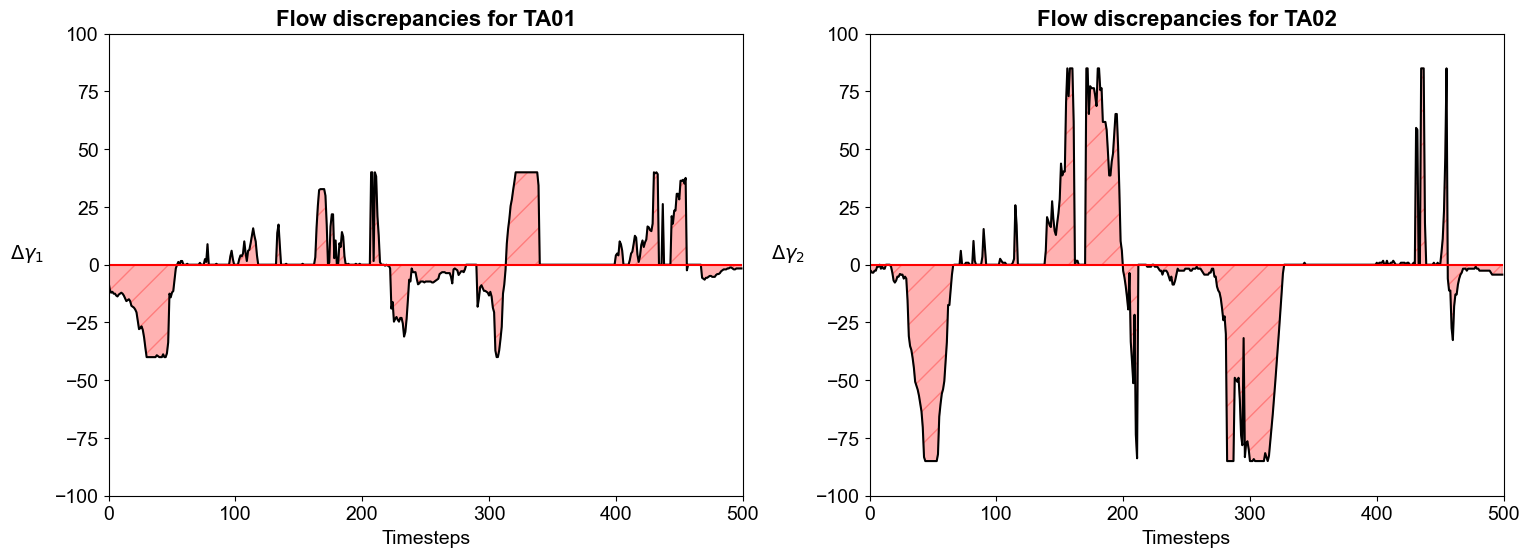

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

ta01_diff = flows_test[:n, 0] - ta01_flow[:n]
ta02_diff = flows_test[:n, 1] - ta02_flow[:n]

ax1.plot(ta01_diff, linewidth=1.5, color='black')
ax1.plot(range(n), np.zeros(n), color='red')#, ls='--')
ax1.fill_between(range(n), ta01_diff, np.zeros(n), color='red', alpha=0.3, hatch='/')

ax1.set_xlim(0, n)
ax1.set_ylim(-100, 100)
ax1.set_ylabel('$\Delta\gamma_1$', rotation=0, labelpad=20)
ax1.set_xlabel('Timesteps')
ax1.set_title('Flow discrepancies for TA01', **tit_font)

ax2.plot(ta02_diff, linewidth=1.5, color='black')
ax2.plot(range(n), np.zeros(n), color='red')#, ls='--')
ax2.fill_between(range(n), ta02_diff, np.zeros(n), color='red', alpha=0.3, hatch='/')

ax2.set_xlim(0, n)
ax2.set_ylim(-100, 100)
ax2.set_ylabel('$\Delta\gamma_2$', rotation=0, labelpad=20)
ax2.set_xlabel('Timesteps')
ax2.set_title('Flow discrepancies for TA02', **tit_font)

plt.savefig(plot_path + 'model_flow_errors.png', dpi=200, bbox_inches='tight')
plt.show()

## Other plots

In [18]:
n_steps = 10000

### Temperature and Humidity SENSOR MERGE

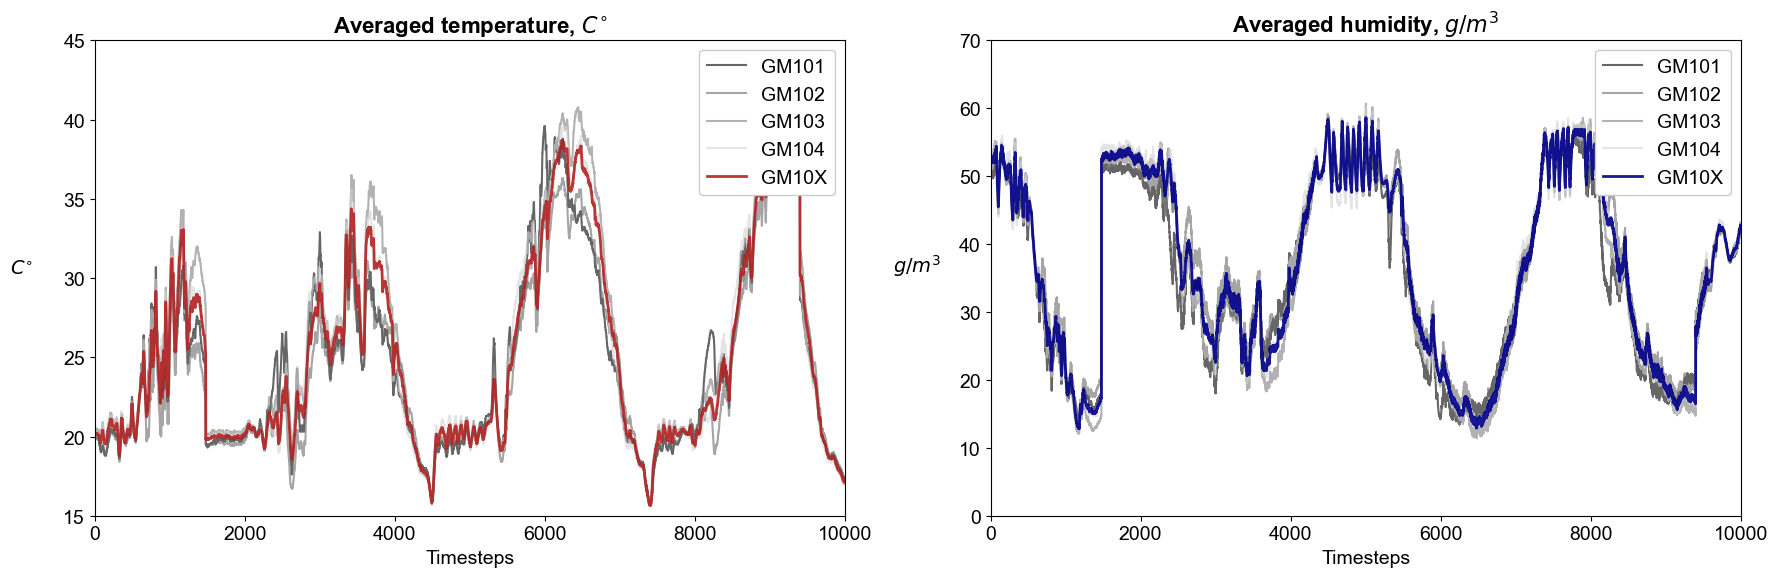

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)


ax1.plot(data.temperatures.DC_GT101_GM101.values[-n_steps:], color='black', alpha=0.6, label='GM101')
ax1.plot(data.temperatures.DC_GT102_GM102.values[-n_steps:], color='dimgrey', alpha=0.6, label='GM102')
ax1.plot(data.temperatures.DC_GT103_GM103.values[-n_steps:], color='grey', alpha=0.6, label='GM103')
ax1.plot(data.temperatures.DC_GT104_GM104.values[-n_steps:], color='lightgrey', alpha=0.6, label='GM104')
ax1.plot(data.temperatures.TA01_GT10X_GM10X.values[-n_steps:], color='firebrick', linewidth=2.0, alpha=0.9, label='GM10X')

ax1.set_ylim(15, 45)
ax1.set_xlim(0, n_steps)
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('$C^{\circ}$', rotation=0, labelpad=30)
ax1.legend(loc='upper right', framealpha=1.0)
ax1.set_title('Averaged temperature, $C^{\circ}$', **tit_font)

ax2.plot(data.humidity.DC_GT101_GM101.values[-n_steps:], color='black', alpha=0.6, label='GM101')
ax2.plot(data.humidity.DC_GT102_GM102.values[-n_steps:], color='dimgrey', alpha=0.6, label='GM102')
ax2.plot(data.humidity.DC_GT103_GM103.values[-n_steps:], color='grey', alpha=0.6, label='GM103')
ax2.plot(data.humidity.DC_GT104_GM104.values[-n_steps:], color='lightgrey', alpha=0.6, label='GM104')
ax2.plot(data.humidity.TA01_GT10X_GM10X.values[-n_steps:], color='darkblue', linewidth=2.0, alpha=0.9, label='GM10X')

ax2.set_xlim(0, n_steps)
ax2.set_ylim(0, 70)
ax2.set_xlabel('Timesteps')
ax2.set_ylabel('$g/m^3$', rotation=0, labelpad=30)
ax2.legend(loc='upper right', framealpha=1.0)
ax2.set_title('Averaged humidity, $g/m^3$', **tit_font)

fig.tight_layout()
plt.savefig(plot_path + 'model_avgs', dpi=200, bbox_inches='tight')
plt.show()

### Highly correlated flows

In [83]:
data.temperatures.columns

Index(['TA01_GT10X_GM10X', 'DC_GT101_GM101', 'DC_GT102_GM102',
       'DC_GT103_GM103', 'DC_GT104_GM104', 'DC_GT401_GM401',
       'TA01_GT401_GM401', 'TA02_GT401_GM401', 'DC_GT301_damped',
       'DC_GT301_outdoor', 'TA01_GT401_GM401_rel', 'TA02_GT401_GM401_rel',
       'DC_GT301_outdoor_rel', 'DC_GT301_damped_rel',
       'TA01_GT401_GM401_scaled', 'TA02_GT401_GM401_scaled',
       'DC_GT301_damped_scaled', 'DC_GT301_outdoor_scaled', 'TA_inflow',
       'TA_inflow_out'],
      dtype='object', name='sensor_ID')

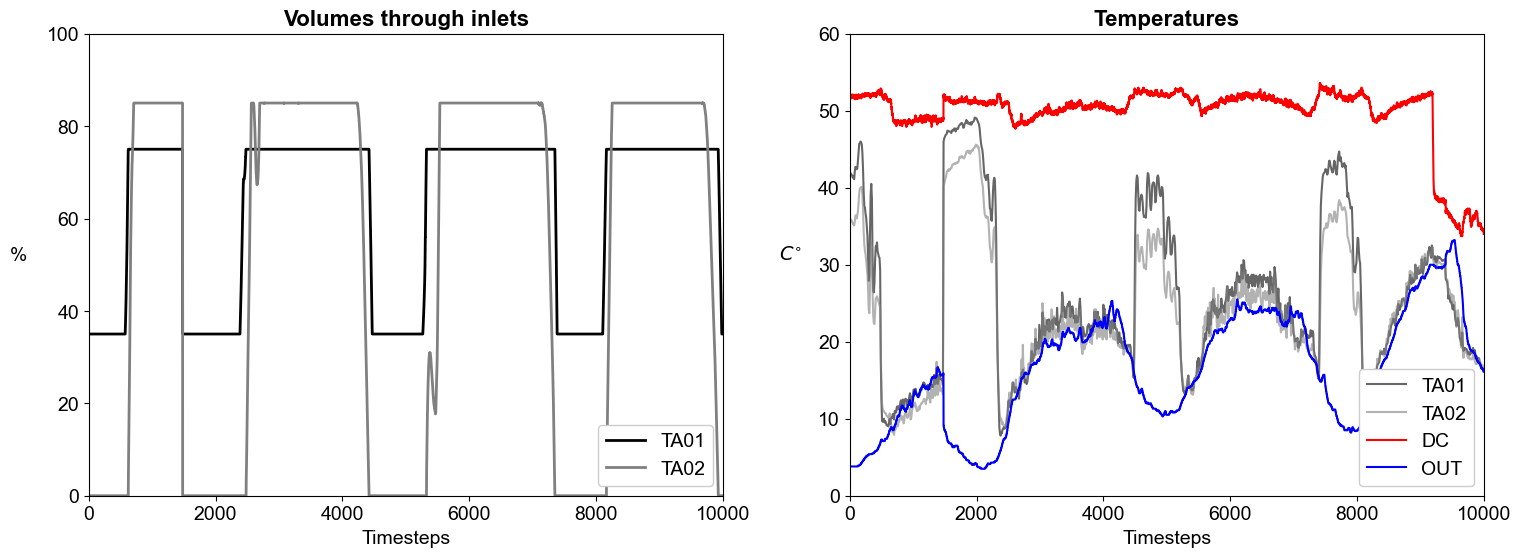

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

# ax1.plot(data.flow.TA01_GP101.values[-n_steps:], color='black', label='TA01')
# ax1.plot(data.flow.TA02_GP101.values[-n_steps:], color='darkgrey', label='TA02')
ax1.plot(data.state.TA01_output.values[-n_steps:], color='black', linewidth=2.0, label='TA01')
ax1.plot(data.state.TA02_output.values[-n_steps:], color='grey', linewidth=2.0, label='TA02')

ax1.set_ylim(0, 100)
ax1.set_xlim(0, n_steps)
ax1.set_ylabel('%', rotation=0, labelpad=20)
ax1.set_xlabel('Timesteps')
ax1.legend(loc='lower right', framealpha=1.0)
ax1.set_title('Volumes through inlets', **tit_font)

ax2.plot(range(0, n_steps)[::10], data.temperatures.TA01_GT401_GM401.values[-n_steps:][::10], alpha=0.6, color='black', label='TA01')
ax2.plot(range(0, n_steps)[::10], data.temperatures.TA02_GT401_GM401.values[-n_steps:][::10], alpha=0.6, color='grey', label='TA02')
ax2.plot(data.temperatures.DC_GT401_GM401.values[-n_steps:], color='red', label='DC')
ax2.plot(data.temperatures.DC_GT301_damped.values[-n_steps:], color='blue', label='OUT')

ax2.set_ylim(0, 60)
ax2.set_xlim(0, n_steps)
ax2.set_ylabel('$C^{\circ}$', rotation=0, labelpad=20)
ax2.set_xlabel('Timesteps')
ax2.legend(loc='lower right', framealpha=1.0)
ax2.set_title('Temperatures', **tit_font)

plt.savefig(plot_path + 'model_flows', dpi=200, bbox_inches='tight')
plt.show()

### Temperature discrepancies - dists

In [56]:
subset_first = data[(data.index.get_level_values(0) == 12) | (data.index.get_level_values(0) < 3)]
subset_second = data[(data.index.get_level_values(0) < 12) & (data.index.get_level_values(0) >= 3)]
subset_first = subset_first.temperatures.TA01_GT10X_GM10X.values - subset_first.setpoints.TA01_GT10X_GM10X.values
subset_second = subset_second.temperatures.TA01_GT10X_GM10X.values - subset_second.setpoints.TA01_GT10X_GM10X.values

In [32]:
# from matplotlib import colors

# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, tight_layout=True)
# fig.set_size_inches(18, 6)

# for ax, data in zip([ax1, ax2], [subset_first, subset_second]):
#     ax.grid(visible=True, alpha=0.5)
#     N, bins, patches = ax.hist(x=data, bins=100, range=(-10, 10), color='orange', alpha=0.9)
    
# #     fracs = N / N.max()
# #     norm = colors.Normalize(fracs.min(), fracs.max())
# #     for frac, patch in zip(fracs, patches):
# #         color = plt.cm.autumn_r(norm(frac))
# #         patch.set_facecolor(color)
    
# ax1.set_xlim(-10, 10)
# ax1.set_ylim(0, 50000)
# ax2.set_xlim(-10, 10)
# #ax2.set_ylim(0, 50000)
# ax1.set_xlabel('$\Delta\\tau$')
# ax2.set_xlabel('$\Delta\\tau$')

# ax1.set_title('Dec - Feb', **suptit_font)
# ax2.set_title('Mar - May', **suptit_font)
# fig.suptitle('Divergencies from setpoint temperature', **suptit_font)
# plt.savefig(plot_path + 'model_divergences.png', dpi=200, bbox_inches='tight')
# plt.show()

### Temperature discrepancies

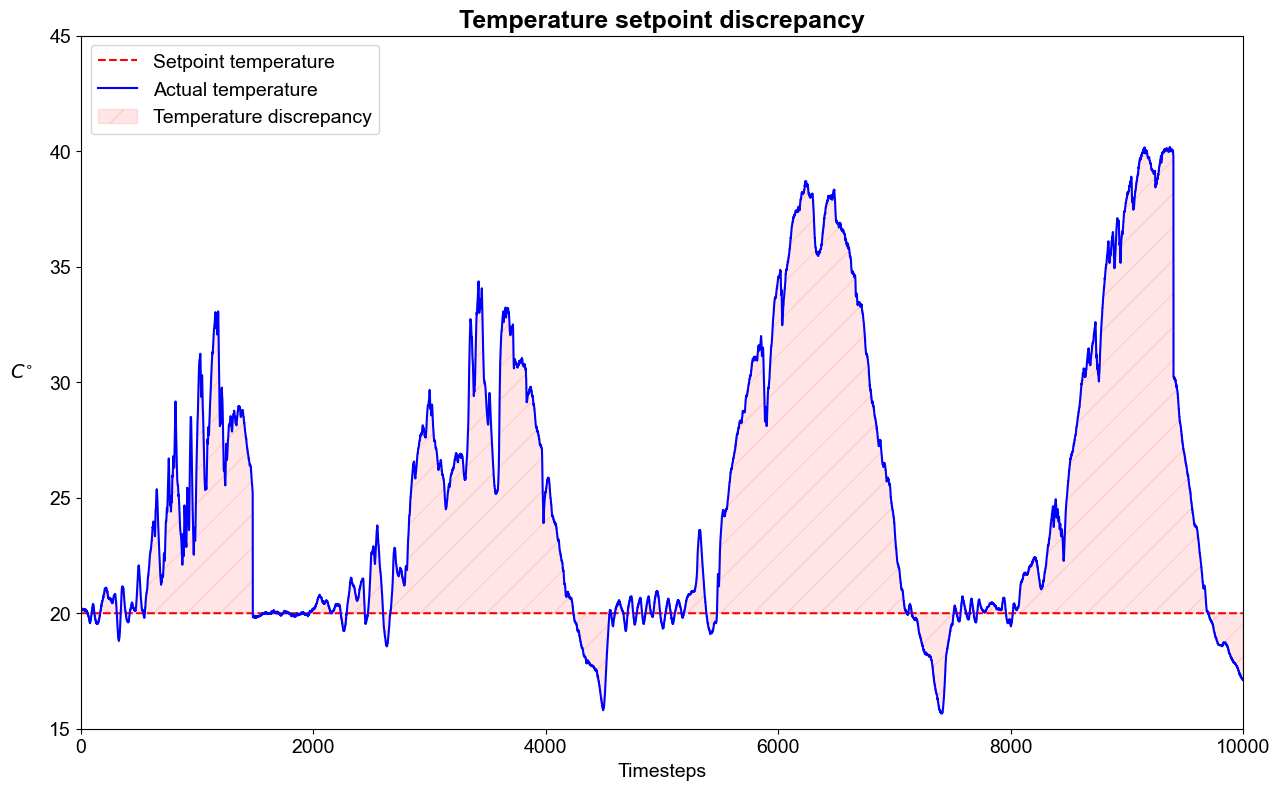

In [248]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)

setpoints = data.setpoints.TA01_GT10X_GM10X.values[-n_steps:]
temps = data.temperatures.TA01_GT10X_GM10X.values[-n_steps:]

ax.plot(setpoints, c='red', ls='--', label='Setpoint temperature')
ax.plot(temps, c='blue', label='Actual temperature')
ax.fill_between(range(0, n_steps), setpoints, temps, color='red', alpha=0.1, hatch='/', label='Temperature discrepancy')

ax.set_xlim(0, n_steps)
ax.set_ylim(15, 45)

ax.set_ylabel('$C^{\circ}$', rotation=0, labelpad=20)
ax.set_xlabel('Timesteps')
ax.legend(loc='upper left')
ax.set_title('Temperature setpoint discrepancy', **suptit_font)

plt.savefig(plot_path + 'model_background_1.png', dpi=200, bbox_inches='tight')
plt.show()

### GSI and flow

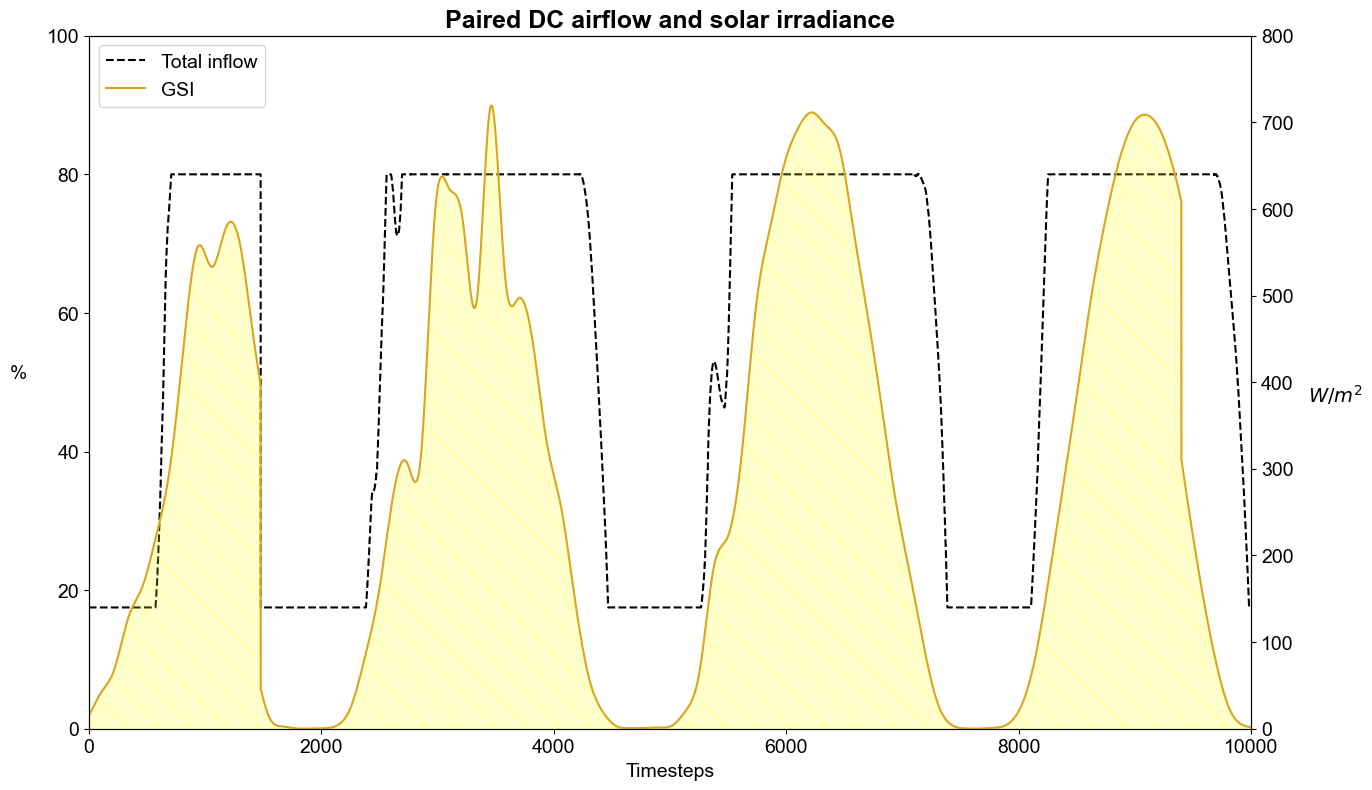

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)

vals = (data.state.TA01_output.values[-n_steps:] + data.state.TA02_output.values[-n_steps:]) / 2
ax.plot(vals, color='black', ls='--', label='Total inflow')
ax.plot(0, 0, color='goldenrod', label='GSI')

ax.set_xlim(0, n_steps)
ax.set_ylim(0, 100)

ax.set_ylabel('%', rotation=0, labelpad=20)
ax.set_xlabel('Timesteps')
ax.legend(loc='upper left')

ax_twin = ax.twinx()
ax_twin.plot(data.sun.gsi.values[-n_steps:], c='goldenrod')
ax_twin.fill_between(range(0, n_steps), 0, data.sun.gsi.values[-n_steps:], hatch='\\', color='yellow', alpha=0.2)
ax_twin.set_ylim(0, 800)
ax_twin.set_ylabel('$W/m^2$', rotation=0, labelpad=30)

ax.set_title('Paired DC airflow and solar irradiance', **suptit_font)

plt.savefig(plot_path + 'model_background_2.png', dpi=200, bbox_inches='tight')
plt.show()

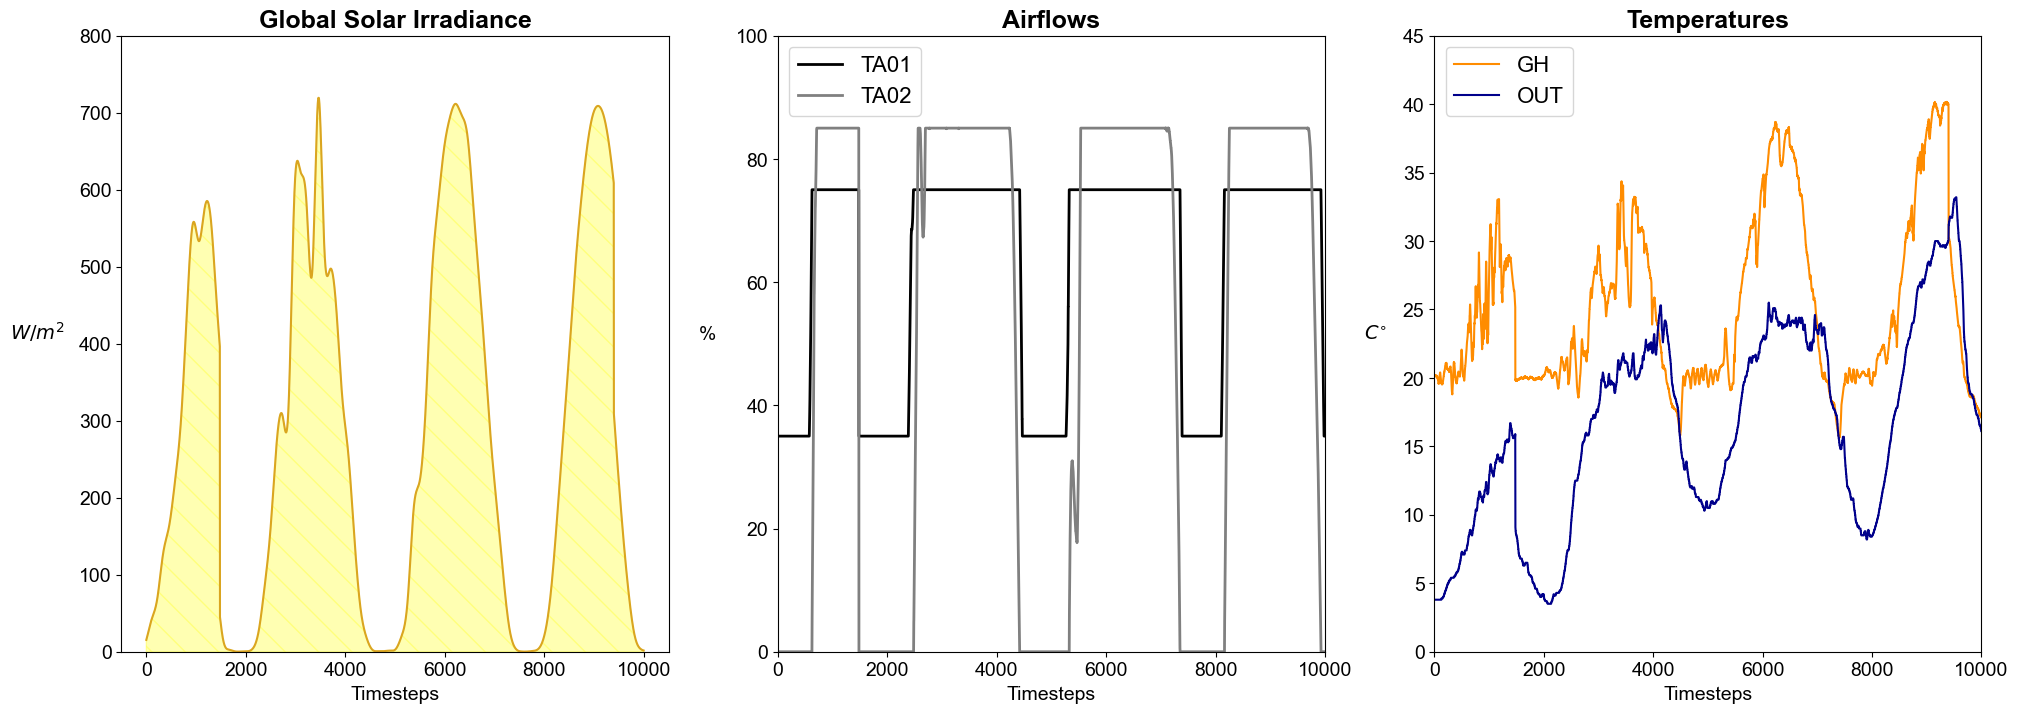

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(24, 8)

ax1.plot(data.sun.gsi.values[-n_steps:], c='goldenrod')
ax1.fill_between(range(0, n_steps), 0, data.sun.gsi.values[-n_steps:], hatch='\\', color='yellow', alpha=0.3)
ax1.set_ylim(0, 800)
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('$W/m^2$', rotation=0, labelpad=30)
ax1.set_title('Global Solar Irradiance', **suptit_font)

# vals = (data.state.TA01_output.values[-n_steps:] + data.state.TA02_output.values[-n_steps:]) / 2
# ax2.plot(vals, color='black', ls='--', label='Total inflow')

ax2.plot(data.state.TA01_output.values[-n_steps:], linewidth=2, c='black', label='TA01')
ax2.plot(data.state.TA02_output.values[-n_steps:], linewidth=2, c='grey', label='TA02')
ax2.set_xlim(0, n_steps)
ax2.set_ylim(0, 100)
ax2.set_ylabel('%', rotation=0, labelpad=20)
ax2.set_xlabel('Timesteps')
ax2.set_title('Airflows', **suptit_font)
ax2.legend(loc='upper left', fontsize=16)

ax3.plot(data.temperatures.TA01_GT10X_GM10X.values[-n_steps:], color='darkorange', label='GH')
ax3.plot(data.temperatures.DC_GT301_damped.values[-n_steps:], color='darkblue', label='OUT')
ax3.set_xlim(0, n_steps)
ax3.set_ylim(0, 45)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('$C^{\circ}$', rotation=0, labelpad=20)
ax3.set_title('Temperatures', **suptit_font)
ax3.legend(loc='upper left', fontsize=16)

plt.savefig(plot_path + 'model_background_4.png', dpi=200, bbox_inches='tight')
plt.show()

In [33]:
data.flow.columns

Index(['TA01_GP101', 'TA02_GP101'], dtype='object', name='sensor_ID')

### Temp errors and control paired

In [247]:
data.temperatures.columns

Index(['DC_GT101_GM101', 'DC_GT102_GM102', 'DC_GT103_GM103', 'DC_GT104_GM104',
       'DC_GT301_damped', 'DC_GT301_outdoor', 'DC_GT401_GM401',
       'TA01_GT10X_GM10X', 'TA01_GT401_GM401', 'TA02_GT401_GM401'],
      dtype='object', name='sensor_ID')

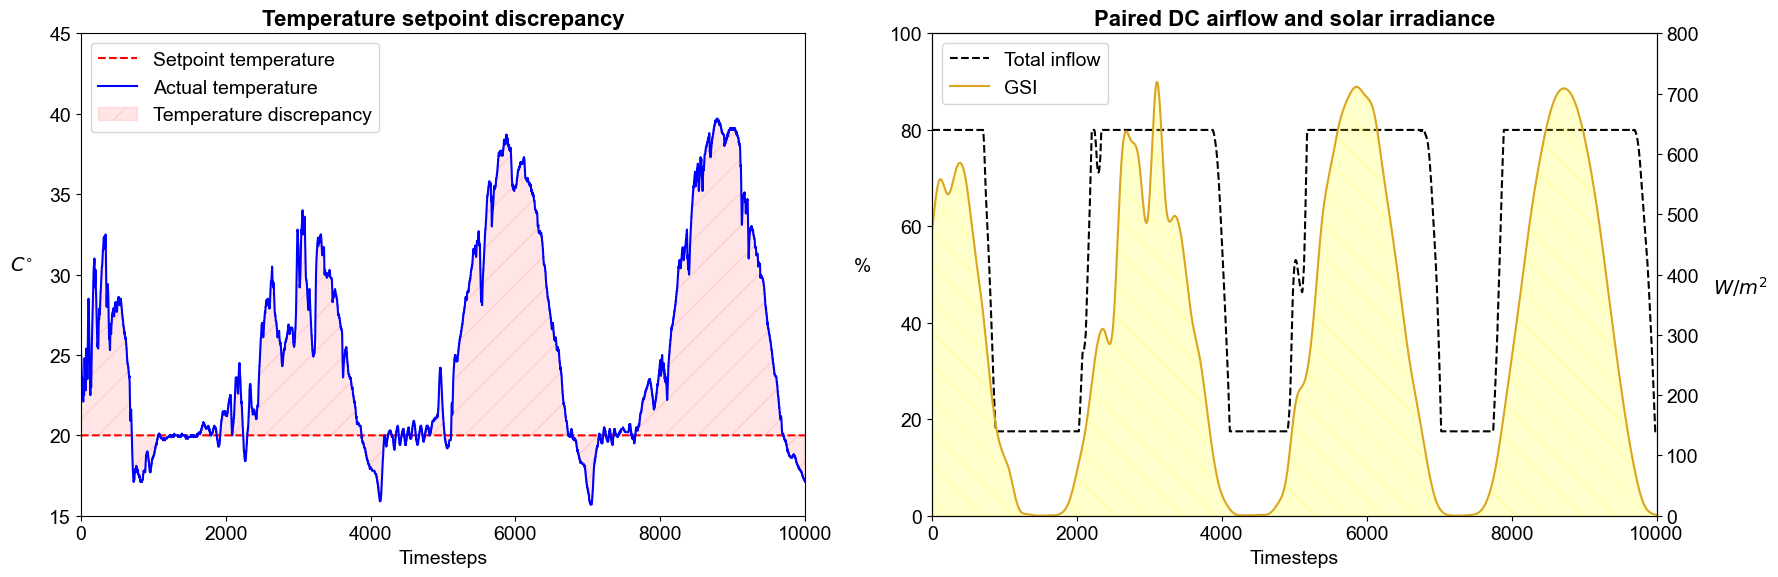

In [254]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

### LEFT PLOT
setpoints = data.setpoints.TA01_GT10X_GM10X.values[-n_steps:]
temps = data.temperatures.TA01_GT10X_GM10X.values[-n_steps:]

ax1.plot(setpoints, c='red', ls='--', label='Setpoint temperature')
ax1.plot(temps, c='blue', label='Actual temperature')
ax1.fill_between(range(0, n_steps), setpoints, temps, color='red', alpha=0.1, hatch='/', label='Temperature discrepancy')

ax1.set_xlim(0, n_steps)
ax1.set_ylim(15, 45)

ax1.set_ylabel('$C^{\circ}$', rotation=0, labelpad=20)
ax1.set_xlabel('Timesteps')
ax1.legend(loc='upper left')
ax1.set_title('Temperature setpoint discrepancy', **tit_font)

### RIGHT PLOT
vals = (data.state.TA01_output.values[-n_steps:] + data.state.TA02_output.values[-n_steps:]) / 2
ax2.plot(vals, color='black', ls='--', label='Total inflow')
ax2.plot(0, 0, color='goldenrod', label='GSI')

ax2.set_xlim(0, n_steps)
ax2.set_ylim(0, 100)

ax2.set_ylabel('%', rotation=0, labelpad=20)
ax2.set_xlabel('Timesteps')
ax2.legend(loc='upper left')

ax_twin = ax2.twinx()
ax_twin.plot(data.sun.gsi.values[-n_steps:], c='goldenrod')
ax_twin.fill_between(range(0, n_steps), 0, data.sun.gsi.values[-n_steps:], hatch='\\', color='yellow', alpha=0.2)
ax_twin.set_ylim(0, 800)
ax_twin.set_ylabel('$W/m^2$', rotation=0, labelpad=30)

ax2.set_title('Paired DC airflow and solar irradiance', **tit_font)

#fig.suptitle('Abc...', **suptit_font)
fig.tight_layout()

plt.savefig(plot_path + 'model_background.png', dpi=200, bbox_inches='tight')
plt.show()

In [61]:
# get original data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
#data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

### Erroneous measurements

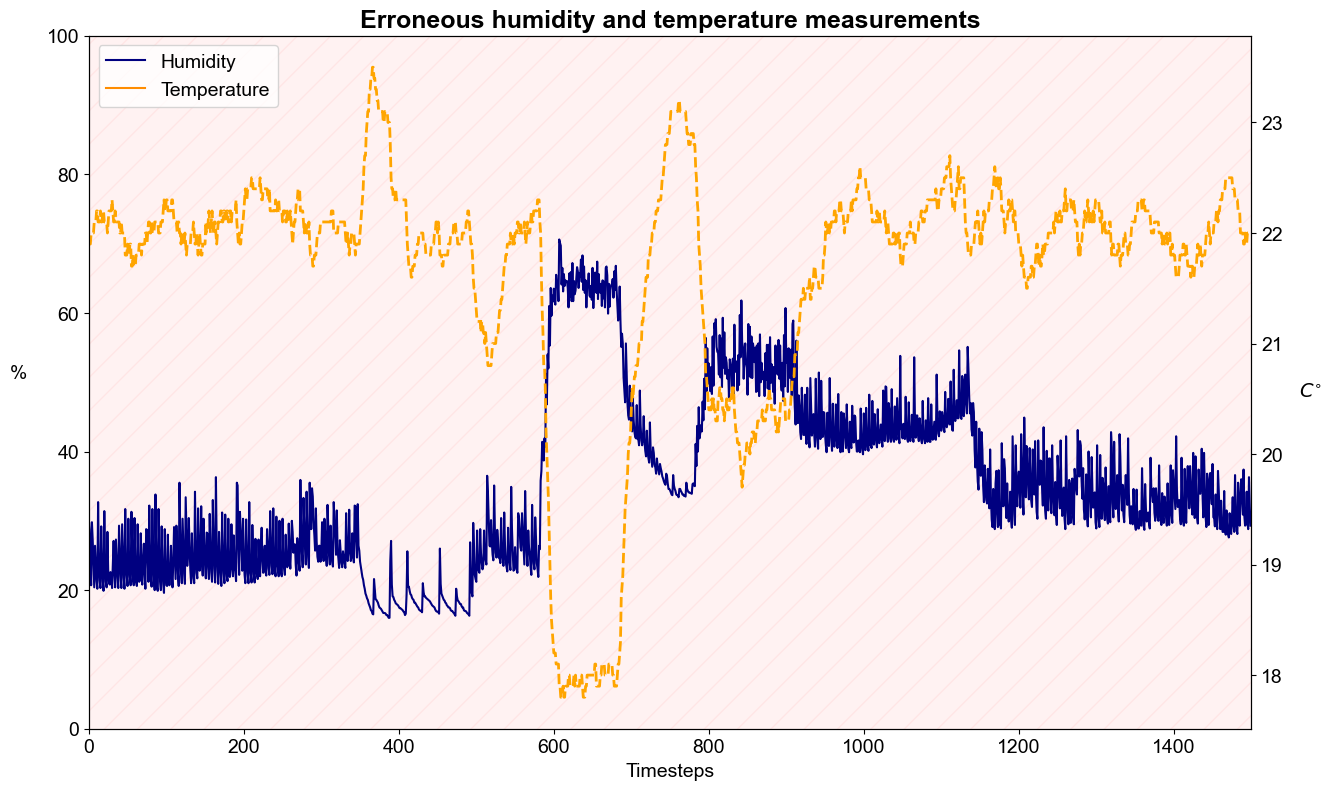

In [243]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)

ax.plot(data.humidity.TA01_GT10X_GM10X.values[1000:2500], color='navy', linewidth=1.5, label='Humidity')
ax.fill_between(range(0, 2000), -100, 200, color='red', hatch='/', alpha=0.05)
ax.set_ylim(0, 100)
ax.set_xlim(0, 1500)
ax.set_xlabel('Timesteps')
ax.set_ylabel('%', rotation=0, labelpad=20)

ax.plot(0, 0, color='darkorange', label='Temperature')
ax.legend(loc='upper left')

ax_twin = ax.twinx()
ax_twin.plot(data.temperatures.TA01_GT10X_GM10X.values[1000:2500], color='orange', ls='--', linewidth=2.0)
ax_twin.set_ylabel('$C^{\circ}$', rotation=0, labelpad=20)

ax.set_title('Erroneous humidity and temperature measurements', **suptit_font)

plt.savefig(plot_path + 'model_background_3.png', dpi=200, bbox_inches='tight')
plt.show()

### GSI

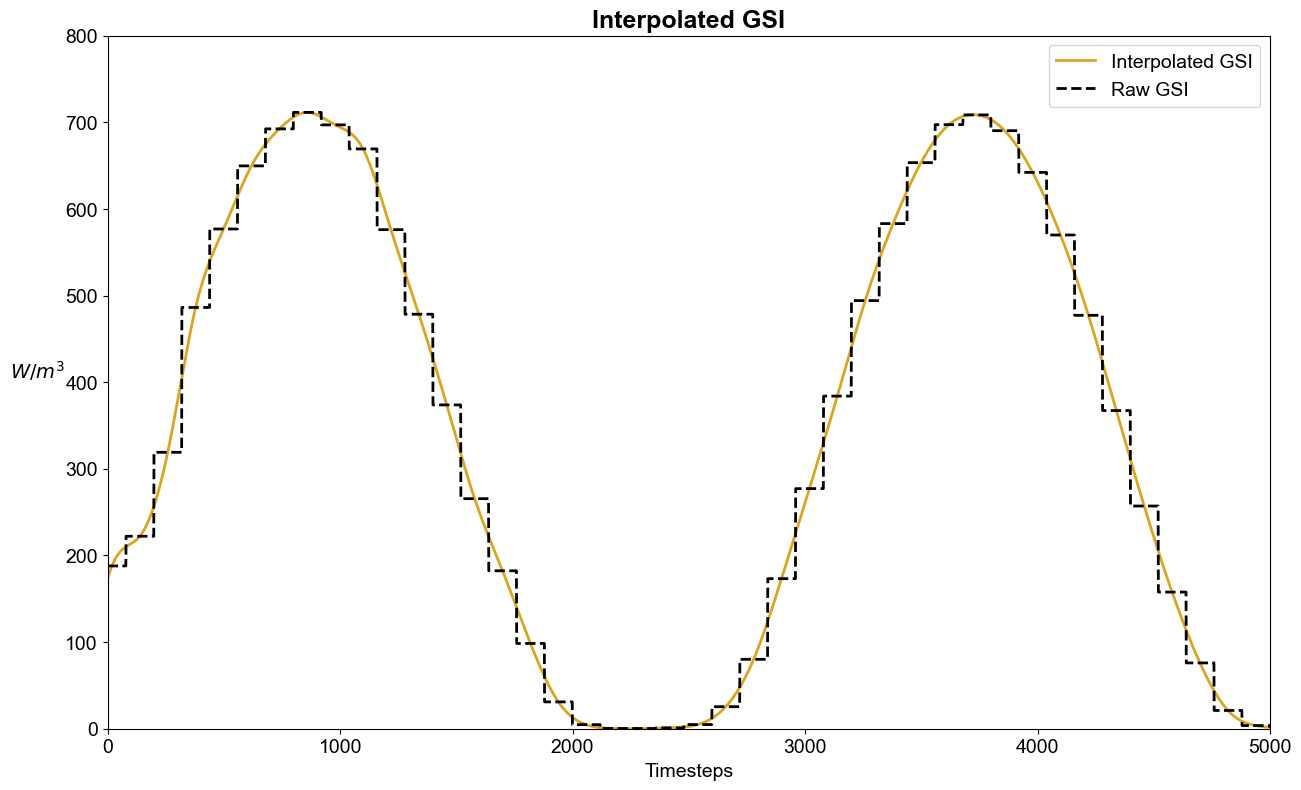

In [132]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)


ax.plot(data.sun.gsi.values[-5000:], color='goldenrod', linewidth=2.0, label='Interpolated GSI')
ax.plot(data.sun.gsi_raw.values[-5000:], color='black', ls='--', linewidth=2.0, label='Raw GSI')

ax.set_xlim(0, 5000)
ax.set_ylim(0, 800)

ax.set_ylabel('$W/m^3$', rotation=0, labelpad=20)
ax.set_xlabel('Timesteps')
ax.legend(loc='upper right')

ax.set_title('Interpolated GSI', **suptit_font)

plt.savefig(plot_path + 'model_gsi.png', dpi=200, bbox_inches='tight')
plt.show()

### Sine-Time

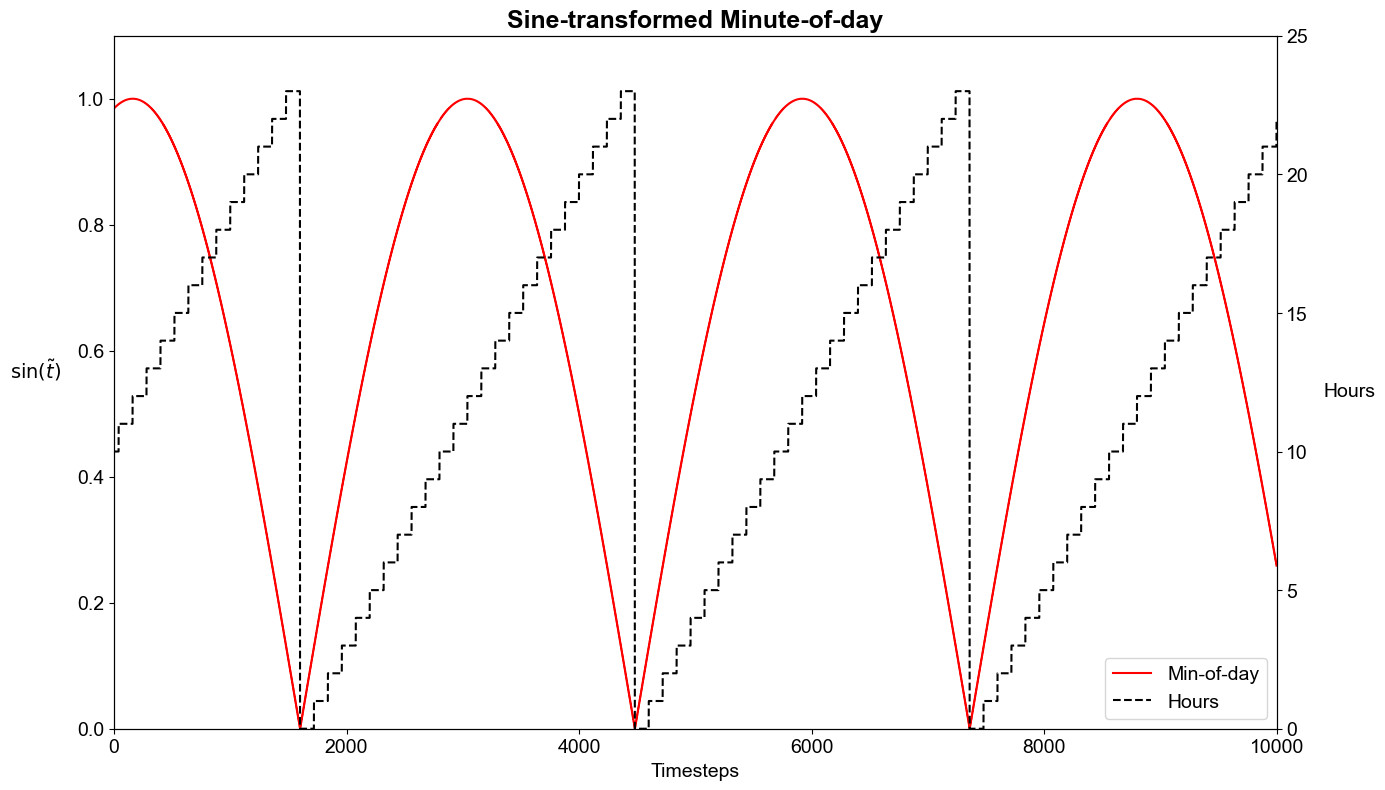

In [169]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)

ax.plot(data.time.minofday.values[-n_steps:], color='red', label='Min-of-day')
ax.plot(0, 0, color='black', ls='--', label='Hours')
ax.set_xlim(0, n_steps)
ax.set_ylim(0, 1.1)
ax.set_ylabel('$\sin(\\tilde{t})$', rotation=0, labelpad=30)
ax.set_xlabel('Timesteps')

ax2 = ax.twinx()
ax2.plot(data.index.get_level_values(2)[-n_steps:], color='black', ls='--')
ax2.set_ylabel('Hours', rotation=0, labelpad=30)
ax2.set_ylim(0, 25)

ax.set_title('Sine-transformed Minute-of-day', **suptit_font)
ax.legend(loc='lower right')

plt.savefig(plot_path + 'model_time.png', dpi=200, bbox_inches='tight')

### GSI and Sine-Time paired

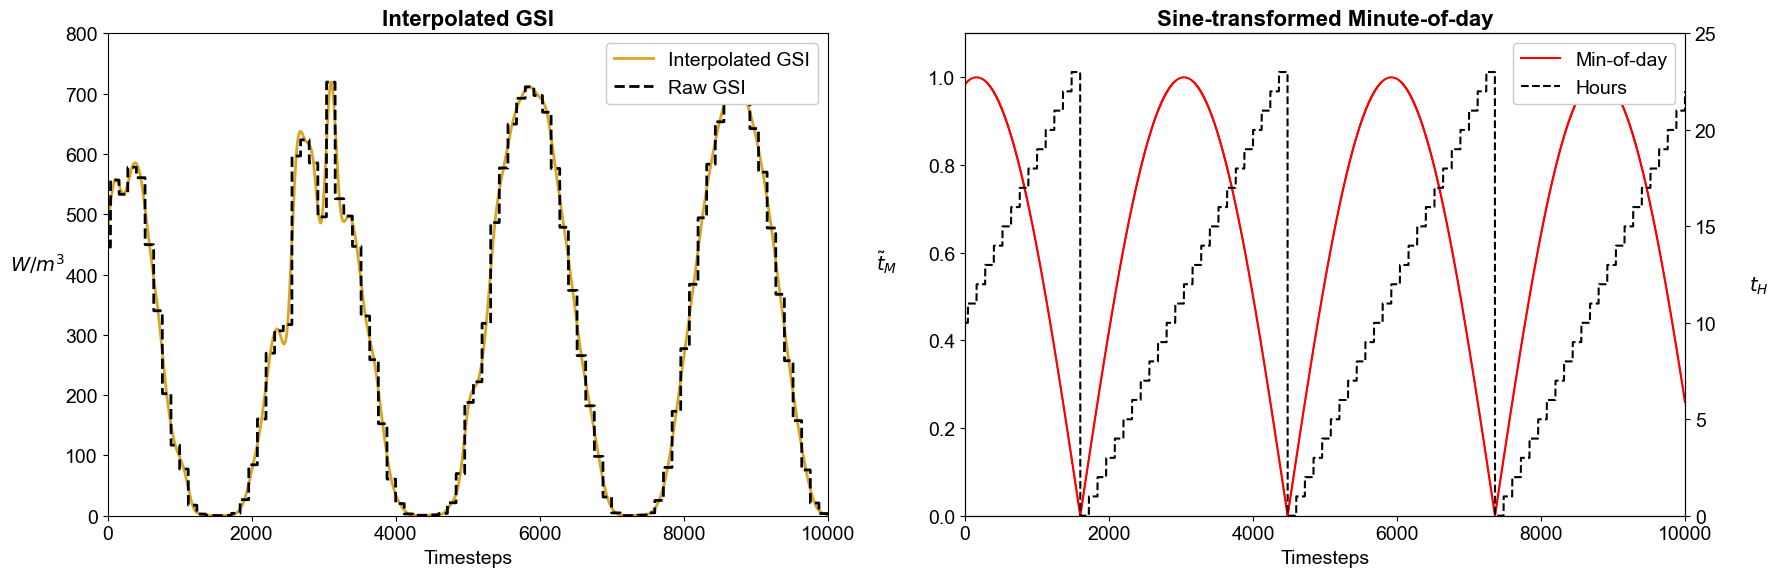

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

n_steps = 10000

ax1.plot(data.sun.gsi.values[-n_steps:], color='goldenrod', linewidth=2.0, label='Interpolated GSI')
ax1.plot(data.sun.gsi_raw.values[-n_steps:], color='black', ls='--', linewidth=2.0, label='Raw GSI')

ax1.set_xlim(0, n_steps)
ax1.set_ylim(0, 800)

ax1.set_ylabel('$W/m^3$', rotation=0, labelpad=20)
ax1.set_xlabel('Timesteps')
ax1.legend(loc='upper right', framealpha=1.0)

ax1.set_title('Interpolated GSI', **tit_font)

ax2.plot(data.time.minofday.values[-n_steps:], color='red', label='Min-of-day')
ax2.plot(0, 0, color='black', ls='--', label='Hours')
ax2.set_xlim(0, n_steps)
ax2.set_ylim(0, 1.1)
ax2.set_ylabel('$\\tilde{t}_M$', rotation=0, labelpad=30)
ax2.set_xlabel('Timesteps')

ax2_twin = ax2.twinx()
ax2_twin.plot(data.index.get_level_values(2)[-n_steps:], color='black', ls='--')
ax2_twin.set_ylabel('$t_H$', rotation=0, labelpad=30)
ax2_twin.set_ylim(0, 25)

ax2.set_title('Sine-transformed Minute-of-day', **tit_font)
ax2.legend(loc='upper right', framealpha=1.0)

fig.tight_layout()
plt.savefig(plot_path + 'model_gsi_time_comb.png', dpi=200, bbox_inches='tight')
plt.show()